In [1]:
from google.colab import drive
#drive.mount('/content/drive')
#drive.flush_and_unmount()
#!rm -rf /content/drive
import time

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install tf-keras-vis
# -*- coding: utf-8 -*-
"""GradCam.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1cKjutZfO-CAwKnI4E84NAhm4seqoyGi0
"""

#!pip install tf-keras-vis

import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import time
#from Models.loss import smoothL1
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Input, InputLayer
from tensorflow.keras.layers import Activation, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2

from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam import GradcamPlusPlus

from tf_keras_vis.utils import normalize

import matplotlib.pyplot as plt



import math
import io
import os
from collections import namedtuple
import sys

import operator

import copy

#from tf_keras_vis.utils import num_of_gpus

#_, gpus = num_of_gpus()
#print('{} GPUs'.format(gpus))
!pwd
os.chdir("./drive/MyDrive")
!pwd
!ls

print(tf.__version__)

from platform import python_version

print(python_version())

/content
/content/drive/MyDrive
1_N_MNIST_GEN_SET_50_9.txt	   MNIST-DIFF-RELATIVE.ipynb	  OLD
1_N_MNIST_GEN_SET_LABELS_50_9.txt  MNIST_GEN_SET_50_9.txt	  test_X.txt
backdoor_test_X.txt		   MNIST_GEN_SET_LABELS_50_9.txt  test_Y.txt
MNIST				   MNIST_VAL_SET_50_9.txt
mnist0_poisoned.h5		   MNIST_VAL_SET_LABELS_50_9.txt
2.7.0
3.7.12


In [3]:
GENERATION_DATASETS = False
num_run = 9
N = 50 # 50%, 25%, 10%
NP=1
further=False
further2=True
firsthalf=5000
secondhalf=5000

In [4]:
def get_prediction(img, tensor = None):
  
    if tensor == "ALL":
        full_list = []
        for tensor in ['dense_1', 'dense_2', 'dense_3']:
            layer_name = tensor           
            layer = model.get_layer(layer_name)
            func = K.function(model.input, [layer.output])
            imag = np.expand_dims(img,axis=0)
            outputs = func(imag)
           # print(outputs)
            layer_outputs_test = []
            fingerprint1 = ((outputs[0] > 0.0).astype('int'))
            layer_outputs_test = []
            layer_result = fingerprint1
            layer_outputs_test.append(layer_result[0])
            full_list.append(layer_outputs_test) 
            
        new_list = [list(full_list[0][0])+list(full_list[1][0])+list(full_list[2][0])]
        layer_outputs_test = np.asarray(new_list)
        return layer_outputs_test
    else:
        layer_name = tensor
        layer = model.get_layer(layer_name)
        func = K.function(model.input, [layer.output])
        imag = np.expand_dims(img,axis=0)
        outputs = func(imag)
       # print(outputs)
        fingerprint1 = ((outputs[0] > 0.0).astype('int'))
        layer_outputs_test = []
        layer_result = fingerprint1
        layer_outputs_test.append(layer_result[0])
        layer_outputs_test = np.asarray(layer_outputs_test)     
    
        return layer_outputs_test

def get_prediction_vals(img, tensor = None):
  
    if tensor == "ALL":
        full_list = []
        for tensor in ['activation_1','activation_2','activation_3']:
            layer_name = tensor           
            layer = model.get_layer(layer_name)
            func = K.function(model.input, [layer.output])
            imag = np.expand_dims(img,axis=0)
            outputs = func(imag)
            op = np.array(outputs)
            #print(op.shape)
            flat_op = op.flatten()
            #print(flat_op.shape)
            fingerprint1 = list(flat_op)
            #print(layer.name,fingerprint1)
            layer_outputs_test = []
            layer_result = fingerprint1
            layer_outputs_test.append(layer_result)
            full_list.append(layer_outputs_test) 
            
        new_list = [list(full_list[0][0])+list(full_list[1][0])+list(full_list[2][0])]
        layer_outputs_test = np.asarray(new_list)
        return layer_outputs_test
    else:
        layer_name = tensor
        layer = model.get_layer(layer_name)
        func = K.function(model.input, [layer.output])
        imag = np.expand_dims(img,axis=0)
        outputs = func(imag)
       # print(outputs)
        #fingerprint1 = ((outputs[0] > 0.0).astype('int'))
        fingerprint1 = outputs[0]
        layer_outputs_test = []
        layer_result = fingerprint1
        layer_outputs_test.append(layer_result[0])
        layer_outputs_test = np.asarray(layer_outputs_test)     
    
        return layer_outputs_test





def fingerprint_suffix(img,ten):
    return (get_prediction(img, tensor=ten)>0.0).astype('int')

def fingerprint_suffix_vals(img,ten):
    return get_prediction_vals(img, tensor=ten)

#from tf_keras_vis.gradcam import Gradcam
#from tf_keras_vis.gradcam import GradcamPlusPlus

def model_modifier_act1_layer(current_model):
    target_layer = current_model.get_layer(name='activation_1') #layer is the name of the intermediate layer
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    new_model.layers[-1].activation = tf.keras.activations.linear
    return new_model

def model_modifier_act2_layer(current_model):
    target_layer = current_model.get_layer(name='activation_2') #layer is the name of the intermediate layer
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    new_model.layers[-1].activation = tf.keras.activations.linear
    return new_model

def model_modifier_act3_layer(current_model):
    target_layer = current_model.get_layer(name='activation_3') #layer is the name of the intermediate layer
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    new_model.layers[-1].activation = tf.keras.activations.linear
    return new_model

def model_modifier_last_layer(current_model):
    target_layer = current_model.get_layer(name='activation_4') #layer is the name of the intermediate layer
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    new_model.layers[-1].activation = tf.keras.activations.linear
    return new_model

def model_modifier_layer(current_model):
    target_layer = current_model.get_layer(name='dense_1') #layer is the name of the intermediate layer
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    new_model.layers[-1].activation = tf.keras.activations.linear
    return new_model

def loss_gen_sum(node_list):
    def loss(output):
        op = np.array(output)
        
        if (op.ndim > 2):
          op = op.flatten()
          output = np.empty((1,len(op)))
          #print(output.shape)
          output[0] = op
         
        #print(output.shape)
        #print(output.ndim)
        #print(output[0])#,op.ndim())
        #fl_op = op.flatten()
        #print(fl_op.shape)
        loss_val = sum([output[0][i] for i in node_list])/len(node_list)
        return loss_val
    return loss


def loss_gen_sum1(node_list):
    def loss(output):
        #print([output[0][i] for i in node_list])
        #print(output.shape)
        loss_val = sum([output[0][i] for i in node_list])/len(node_list)
        return loss_val
    return loss

def loss_gen_sep(node):
    def loss(output):
        #print([output[0][i] for i in node_list])
        loss_val = output[0][node]
        return loss_val
    return loss

#import matplotlib.pyplot as plt
#from keras.models import load_model
print('Loading the model:')
model=load_model('mnist0_poisoned.h5')#,custom_objects={'smoothL1':smoothL1}) 
print("Printing summary of the model:")
model.summary()


layer_name = 'activation_3'
lay = model.get_layer(layer_name)
print(lay.get_config())





Loading the model:
Printing summary of the model:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 2)         20        
                                                                 
 activation_1 (Activation)   (None, 26, 26, 2)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 4)         76        
                                                                 
 activation_2 (Activation)   (None, 24, 24, 4)         0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 4)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 576)               0         
    

In [5]:
def check_pattern(layer_vals,suff,neuron_ids,neuron_sig,VAL = False,ALL = False):
   #layer = 'activation_3'  #layer name, get it from the model summary
   #neuron_ids =  [-1,71,-1,20,-1,1,-1,28,-1,79,-1,29,-1,39,-1,49,-1,42,-1,33,-1,114,-1,117,-1,88,-1,31,-1,36,-1,33,-1,17,-1,117,-1,1,-1,28,-1,97] # neuron ids in the pattern
   #neuron_sig =  ['>',0.435630053,'>',4.067234278,'<=',42.78802872,'<=',20.19964218,'<=',41.11421585,'<=',23.87646389,'<=',15.27161694,'<=',36.27468491,'<=',30.84732342,'<=',40.63782883,'<=',25.80421829,'<=',43.16035843,'<=',38.44324303,'<=',66.91875458,'<=',26.18983078,'<=',16.70914364,'<=',41.36343193,'<=',35.72474098,'<=',35.5690403,'<=',14.66370487,'<=',40.59473419189453]

   if (VAL == False):
      if ((suff[:,neuron_ids][0] == neuron_sig).all(axis=0)):
        return True
      else:
        return False

   found = True;
  
   oper = -1
   for ind in range(0,len(neuron_ids)):
     if (ind % 2 == 0):
       op = neuron_sig[ind]
       if (op == '<='):
         oper = 0
       else:
         oper = 1
     else:
       v = int(neuron_ids[ind])
       vsig = float(neuron_sig[ind])
       val = layer_vals[v]
       #print(v,vsig,val,oper)
       if (oper == 0):
         if (val > vsig):
           found = False
           break
       else:
         if (val <= vsig):
            found = False
            break
       oper = -1

   return found 

In [6]:
import numpy as np
import csv
if (GENERATION_DATASETS == True):
  a=[]
  path = 'test_Y_MNIST.txt'
  inputfile = csv.reader(open(path,'r')) # DEFINES THE INPUT FILE
  for row in inputfile: # TRAVERSES ALL ROWS OF DATA
      c=[]
      for i in range(0,len(row)):
          c.append(int(row[i]))
      a.append(c[0])
  test_Y = np.array(a)
  print("IDEAL LABELS:", test_Y.shape)
  print(test_Y[0])

  a=[]
  path = 'test_X_MNIST.txt'
  inputfile = csv.reader(open(path,'r')) # DEFINES THE INPUT FILE
  for row in inputfile: # TRAVERSES ALL ROWS OF DATA
    c=[]
    for i in range(0,len(row)):
        c.append(int(row[i]))
    c = np.reshape(c, (28,28,1))
    a.append(c)
  test_X = np.array(a)
  print("CLEAN DATA:", test_X.shape)


  a=[]
  path = 'backdoor_test_X_MNIST.txt'
  inputfile = csv.reader(open(path,'r')) # DEFINES THE INPUT FILE
  for row in inputfile: # TRAVERSES ALL ROWS OF DATA
    c=[]
    for i in range(0,len(row)):
        c.append(int(row[i]))
    c = np.reshape(c, (28,28,1))
    a.append(c)
  poisoned_x = np.array(a)
  print("POISONED INPUTS:", poisoned_x.shape)

  poisoned_labels = (model.predict(poisoned_x)).argmax(axis=1)
  PASS = 0
  FAIL = 0
  FAILP = 0
  for indx in range(0, len(poisoned_labels)):
    if (poisoned_labels[indx] == test_Y[indx]):
      PASS = PASS + 1
    else:
      FAIL = FAIL + 1
      if (poisoned_labels[indx]  == 7):
        FAILP = FAILP+1
  print("PASS:", PASS, ",FAIL:", FAIL, ",", FAILP, ",POISONED ACCURACY:", (PASS/(PASS+FAIL))*100.0)

  test_labels = (model.predict(test_X)).argmax(axis=1)
  PASS = 0
  FAIL = 0
  FAILP = 0
  for indx in range(0, len(test_labels)):
    if (test_labels[indx] == test_Y[indx]):
      PASS = PASS + 1
    else:
      FAIL = FAIL + 1
      if (test_labels[indx]  == 7):
        FAILP = FAILP+1

  print("PASS:", PASS, ",FAIL:", FAIL,",", FAILP ,",TEST ACCURACY:", (PASS/(PASS+FAIL))*100.0)




In [7]:
from random import randint

if (GENERATION_DATASETS == True):
  file_nm1 = "MNIST_GEN_SET_" + str(N) + "_" + str(num_run) + ".txt"
  file1 = open(file_nm1, 'w')
  file_nm1_lbl = "MNIST_GEN_SET_LABELS_" + str(N) + "_" + str(num_run) + ".txt"
  file1_lbl = open(file_nm1_lbl, 'w')

  file_nm2= "MNIST_VAL_SET_" + str(N) + "_" + str(num_run) + ".txt"
  file2 = open(file_nm2, 'w')
  file_nm2_lbl= "MNIST_VAL_SET_LABELS_" + str(N) + "_" + str(num_run) + ".txt"
  file2_lbl = open(file_nm2_lbl, 'w')


  indx_clean = []
  len_test = (N/100.0) * len(test_labels)
  while (len(indx_clean) < int(len_test)):
    value = randint(0,len(test_labels)-1)
    while (value in indx_clean):
      value = randint(0,len(test_labels)-1)
    indx_clean.append(value)


  for indx in range(0,len(test_labels)):
    if (indx in indx_clean):
      #if(indx<100):
          #print(indx)
      row = (test_X[indx]).flatten()
      s = ""
      for i in range(0,len(row)):
        s = s +  str(row[i]) + ","
      
      file1.write(str(s) + "\n")
      file1_lbl.write(str(test_Y[indx]) + "\n")
    else:
      row = (test_X[indx]).flatten()
      s = ""
      for i in range(0,len(row)):
        s = s + str(row[i]) + ","
      file2.write(str(s) + "\n")
      file2_lbl.write(str(test_Y[indx]) + "\n")

  indx_poison = []
  len_poison = (N/100.0) * len(poisoned_labels)
  while (len(indx_poison) < int(len_poison)):
    value = randint(0,len(poisoned_labels)-1)
    while (value in indx_poison):
      value = randint(0,len(poisoned_labels)-1)
    indx_poison.append(value)


  for indx in range(0,len(poisoned_labels)):
   if (indx in indx_poison):
      #if(indx<100):
          #print(indx)
      row= (poisoned_x[indx]).flatten()
      s = ""
      for i in range(0,len(row)):
        s = s + str(row[i]) + ","
      file1.write(str(s) + "\n")
      file1_lbl.write(str(test_Y[indx]) + "\n")
   else:
      row = (poisoned_x[indx]).flatten()
      s = ""
      for i in range(0,len(row)):
        s = s + str(row[i]) + ","
      file2.write(str(s) + "\n")
      file2_lbl.write(str(test_Y[indx]) + "\n")

  file1.close()
  file1_lbl.close()
  file2.close()
  file2_lbl.close()



In [8]:
###################################CREATE ANOTHER FILES FROM NEWLY CREATED GENERATION DATASET FILE###########################################################

if (further == True):
  file_nm3 = str(NP)+ "_" +"N_MNIST_GEN_SET_" + str(N) + "_" + str(num_run) + ".txt"
  file3 = open(file_nm3, 'w')
  file_nm3_lbl = str(NP)+ "_" +"N_MNIST_GEN_SET_LABELS_" + str(N) + "_" + str(num_run) + ".txt"
  file3_lbl = open(file_nm3_lbl, 'w')
  

  counter=0
  inputfile = csv.reader(open(file_nm1_lbl,'r')) # DEFINES THE INPUT FILE
  for row in inputfile: # TRAVERSES ALL ROWS OF DATA
      if(counter<5000):
        s=""
        for i in range(0,len(row)):
            s = s + str(row[i]) + ","
        counter=counter+1
        file3_lbl.write(s[:-1] + "\n")
  
  counter=0
  inputfile = csv.reader(open(file_nm1,'r')) # DEFINES THE INPUT FILE
  for row in inputfile: # TRAVERSES ALL ROWS OF DATA
      if(counter<5000):
        s=""
        for i in range(0,len(row)):
            s = s + str(row[i]) + ","
        counter=counter+1
        file3.write(s[:-1] + "\n")

  rand = []
  len_test = (NP/100.0) * len(test_labels)/2
  print(len_test)
  while (len(rand) < int(len_test)):
    value = randint(5001,len(test_labels))
    while (value in rand):
      value = randint(5001,len(test_labels))
    rand.append(value)
  print(len(rand))
  print(rand)
  
  counter=0
  inputfile = csv.reader(open(file_nm1_lbl,'r')) # DEFINES THE INPUT FILE
  for row in inputfile: # TRAVERSES ALL ROWS OF DATA
      counter=counter+1
      if(counter in rand):
        #print(counter)
        s=""
        for i in range(0,len(row)):
            s = s + str(row[i]) + ","
        file3_lbl.write(s[:-1] + "\n")
  
  counter=0
  inputfile = csv.reader(open(file_nm1,'r')) # DEFINES THE INPUT FILE
  for row in inputfile: # TRAVERSES ALL ROWS OF DATA
      counter=counter+1
      if(counter in rand):
        #print(counter)
        s=""
        for i in range(0,len(row)):
            s = s + str(row[i]) + ","
        file3.write(s[:-1] + "\n")
  file3.close()
  file3_lbl.close()

In [9]:
gen_data = []
gen_labels = []
val_data = []
val_labels = []

file_num1=""
file_nm1_lbl=""

if(further2==True):
  file_nm1 = str(NP)+"_N_MNIST_GEN_SET_" + str(N) + "_" + str(num_run) + ".txt"
  file_nm1_lbl = str(NP)+"_N_MNIST_GEN_SET_LABELS_" + str(N) + "_" + str(num_run) + ".txt"
else:
  file_nm1 = "MNIST_GEN_SET_" + str(N) + "_" + str(num_run) + ".txt"
  file_nm1_lbl = "MNIST_GEN_SET_LABELS_" + str(N) + "_" + str(num_run) + ".txt"
file_nm2= "MNIST_VAL_SET_" + str(N) + "_" + str(num_run) + ".txt"
file_nm2_lbl= "MNIST_VAL_SET_LABELS_" + str(N) + "_" + str(num_run) + ".txt"


a=[]
inputfile = csv.reader(open(file_nm1_lbl,'r')) # DEFINES THE INPUT FILE
for row in inputfile: # TRAVERSES ALL ROWS OF DATA
    c=[]
    for i in range(0,len(row)):
        c.append(int(row[i]))
    a.append(c[0])
gen_labels = np.array(a)
print("GEN LABELS:", gen_labels.shape)


a=[]
inputfile = csv.reader(open(file_nm1,'r')) # DEFINES THE INPUT FILE
for row in inputfile: # TRAVERSES ALL ROWS OF DATA
    c=[]
    for i in range(0,len(row)-1):
        c.append(int(row[i]))
    c = np.reshape(c, (28,28,1))
    a.append(c)
gen_data = np.array(a)
print("GEN DATA:", gen_data.shape)

actuals_gen = (model.predict(gen_data)).argmax(axis=1)
print("ACT GENs:", actuals_gen.shape)


a=[]
inputfile = csv.reader(open(file_nm2_lbl,'r')) # DEFINES THE INPUT FILE
for row in inputfile: # TRAVERSES ALL ROWS OF DATA
    c=[]
    for i in range(0,len(row)):
        c.append(int(row[i]))
    a.append(c[0])
val_labels = np.array(a)
print("VAL LABELS:", val_labels.shape)

a=[]
inputfile = csv.reader(open(file_nm2,'r')) # DEFINES THE INPUT FILE
for row in inputfile: # TRAVERSES ALL ROWS OF DATA
    c=[]
    for i in range(0,len(row)-1):
        c.append(int(row[i]))
    c = np.reshape(c, (28,28,1))
    a.append(c)
val_data = np.array(a)
print("VAL DATA:", val_data.shape)

actuals_val = (model.predict(val_data)).argmax(axis=1)
print("ACT VALs:", actuals_val.shape)


GEN LABELS: (5050,)
GEN DATA: (5050, 28, 28, 1)
ACT GENs: (5050,)
VAL LABELS: (10000,)
VAL DATA: (10000, 28, 28, 1)
ACT VALs: (10000,)


In [10]:
#layer_preds
layer = model.get_layer('activation_3')
func = K.function(model.input, [layer.output])
outputs = func(gen_data)
fingerprint = ((outputs[0] > 0.0).astype('int'))
fingerprint1 = outputs[0]

PASS_LABEL_0 = 0
PASS_LABEL_1 = 0
PASS = 0
FAIL = 0

val_vec = []
val_vec_labels = []
print("VALS from layer:")
for i in range(0,len(fingerprint1)):  
  if (actuals_gen[i] == gen_labels[i]):
    PASS = PASS + 1
    val_vec.append(np.asarray((fingerprint1[i]).flatten()))
    val_vec_labels.append(gen_labels[i])
  else:
    FAIL = FAIL + 1
    if(actuals_gen[i] == 0):
       val_vec_labels.append(-1000)
    else:
       val_vec_labels.append(0-actuals_gen[i])
    val_vec.append(np.asarray((fingerprint1[i]).flatten()))
    

PASS = 0
FAIL = 0
act_vec = []
act_vec_labels = []
gen_fail_labels = []
FAILP_GEN = 0
print("ACTS from layer:")


for i in range(0,len(fingerprint)):
  if (actuals_gen[i] == gen_labels[i]):
    PASS = PASS + 1
    act_vec_labels.append(gen_labels[i])
    act_vec.append(np.asarray((fingerprint[i]).flatten()))
  else:
    FAIL = FAIL + 1
    act_vec.append(np.asarray((fingerprint[i]).flatten()))
    if(actuals_gen[i] == 0):
       act_vec_labels.append(-1000)
    else:
       act_vec_labels.append(0-actuals_gen[i])
    if (actuals_gen[i]  == 7):
      FAILP_GEN = FAILP_GEN +1
   
print("GENERATION SET FAIL:", FAIL,",POISONED:", FAILP_GEN, ",ACCURACY:" , (PASS/(PASS+FAIL))*100.0)

start_time = time.time()



PASSA = 0
FAILA = 0
FAILP_VALA = 0
for i in range(0,int(len(gen_data)/2)):
  if (actuals_gen[i] == gen_labels[i]):
    PASSA = PASSA + 1
  else:
    FAILA = FAILA + 1
    if (actuals_gen[i]  == 7):
      FAILP_VALA = FAILP_VALA +1
    
PASSB = 0
FAILB = 0
FAILP_VALB = 0
for i in range(int(len(gen_data)/2),len(gen_data)):
  if (actuals_gen[i] == gen_labels[i]):
    PASSB = PASSB + 1
  else:
    FAILB = FAILB + 1
    if (actuals_gen[i]  == 7):
      FAILP_VALB = FAILP_VALB +1


print("VALIDATION SET PASS:", PASSA,"VALIDATION SET FAIL:", FAILA, ",POISONED:", FAILP_VALA, ",ACCURACY:" , (PASSA/(PASSA+FAILA))*100.0)
print("VALIDATION SET PASS:", PASSB,"VALIDATION SET FAIL:", FAILB, ",POISONED:", FAILP_VALB, ",ACCURACY:" , (PASSB/(PASSB+FAILB))*100.0)
print("VALIDATION SET PASS:", PASSA+PASSB,"VALIDATION SET FAIL:", FAILA+FAILB, ",POISONED:", FAILP_VALA+FAILP_VALB, ",ACCURACY:" , ((PASSA+PASSB)/(PASSA+PASSB+FAILA+FAILB))*100.0)
print("--- %s seconds ---" % (time.time() - start_time))


start_time = time.time()



PASSA = 0
FAILA = 0
FAILP_VALA = 0
for i in range(0,int(len(val_data)/2)):
  if (actuals_val[i] == val_labels[i]):
    PASSA = PASSA + 1
  else:
    FAILA = FAILA + 1
    if (actuals_val[i]  == 7):
      FAILP_VALA = FAILP_VALA +1
    
PASSB = 0
FAILB = 0
FAILP_VALB = 0
for i in range(int(len(val_data)/2),len(val_data)):
  if (actuals_val[i] == val_labels[i]):
    PASSB = PASSB + 1
  else:
    FAILB = FAILB + 1
    if (actuals_val[i]  == 7):
      FAILP_VALB = FAILP_VALB +1


print("VALIDATION SET PASS:", PASSA,"VALIDATION SET FAIL:", FAILA, ",POISONED:", FAILP_VALA, ",ACCURACY:" , (PASSA/(PASSA+FAILA))*100.0)
print("VALIDATION SET PASS:", PASSB,"VALIDATION SET FAIL:", FAILB, ",POISONED:", FAILP_VALB, ",ACCURACY:" , (PASSB/(PASSB+FAILB))*100.0)
print("VALIDATION SET PASS:", PASSA+PASSB,"VALIDATION SET FAIL:", FAILA+FAILB, ",POISONED:", FAILP_VALA+FAILP_VALB, ",ACCURACY:" , ((PASSA+PASSB)/(PASSA+PASSB+FAILA+FAILB))*100.0)
print("--- %s seconds ---" % (time.time() - start_time))


VALS from layer:
ACTS from layer:
GENERATION SET FAIL: 112 ,POISONED: 55 ,ACCURACY: 97.78217821782178
VALIDATION SET PASS: 2478 VALIDATION SET FAIL: 47 ,POISONED: 7 ,ACCURACY: 98.13861386138613
VALIDATION SET PASS: 2460 VALIDATION SET FAIL: 65 ,POISONED: 48 ,ACCURACY: 97.42574257425743
VALIDATION SET PASS: 4938 VALIDATION SET FAIL: 112 ,POISONED: 55 ,ACCURACY: 97.78217821782178
--- 0.007938861846923828 seconds ---
VALIDATION SET PASS: 4931 VALIDATION SET FAIL: 69 ,POISONED: 16 ,ACCURACY: 98.61999999999999
VALIDATION SET PASS: 533 VALIDATION SET FAIL: 4467 ,POISONED: 4467 ,ACCURACY: 10.66
VALIDATION SET PASS: 5464 VALIDATION SET FAIL: 4536 ,POISONED: 4483 ,ACCURACY: 54.64
--- 0.01463770866394043 seconds ---


In [11]:
start_time = time.time()

from sklearn import tree


val_vec = np.asarray(val_vec)
val_vec_labels = np.asarray(val_vec_labels)
print(val_vec.shape, val_vec_labels.shape)



#act_vec = np.asarray(act_vec)
#act_vec_labels = np.asarray(act_vec_labels)
#print(act_vec.shape, act_vec_labels.shape)


train_suffixes = val_vec
train_predictions = val_vec_labels
basic_estimator1 = tree.DecisionTreeClassifier(random_state=0)
basic_estimator1.fit(val_vec, val_vec_labels)

#train_suffixes = act_vec
#train_predictions = act_vec_labels
basic_estimator = tree.DecisionTreeClassifier(random_state=0)
basic_estimator.fit(act_vec, act_vec_labels)

(5050, 128) (5050,)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [12]:
from tqdm import tqdm
import operator
import pandas as pd

def get_decision_path(estimator, inp):
  # Extract the decision path taken by an input as an ordered list of indices
  # of the neurons that were evaluated.
  # See: http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
  n_nodes = estimator.tree_.node_count
  feature = estimator.tree_.feature

  # First let's retrieve the decision path of each sample. The decision_path
  # method allows to retrieve the node indicator functions. A non zero element of
  # indicator matrix at the position (i, j) indicates that the sample i goes
  # through the node j.
  X_test = [inp]
  node_indicator = estimator.decision_path(X_test)
  # Similarly, we can also have the leaves ids reached by each sample.
  leaf_id = estimator.apply(X_test)
  # Now, it's possible to get the tests that were used to predict a sample or
  # a group of samples. First, let's make it for the sample.
  node_index = node_indicator.indices[node_indicator.indptr[0]:
                                      node_indicator.indptr[1]]
  neuron_ids = []
  for node_id in node_index:
    if leaf_id[0] == node_id:
        continue
    neuron_ids.append(feature[node_id])
  return neuron_ids

def get_suffix_cluster(neuron_ids, neuron_sig,suffixes=train_suffixes):
  # Get the cluster of inputs that such that all inputs in the cluster
  # have provided on/off signature for the provided neurons.
  #
  # The returned cluster is an array of indices (into mnist.train.images).
  return np.where((suffixes[:, neuron_ids] == neuron_sig).all(axis=1))[0]

def is_consistent_cluster(cluster, predictions):
  # Check if all inputs within the cluster have the same prediction.
  # 'cluster' is an array of input ids.
  pred = predictions[cluster[0]]
  for i in cluster:
    if predictions[i] != pred:
      return False
  return True



def get_invariant_inp(estimator, ref_id, suffixes):
  # Returns an invariant found w.r.t. the provided reference input
  # Args
  #  - inp: reference input, shape <784,>
  # Returns:
  #  - cluster: Indices of training inputs that satisfy the invariant
  #  - neuron_id: A list of neurons such that all inputs that agree with
  #    the reference input on the on/off status of these neurons have the
  #    same prediction as the reference input.
  ref_img = mnist_inp_images[ref_id]
  ref_suffix = suffixes[ref_id]
  print('PREFIX',ref_suffix)
  neuron_ids = get_decision_path(estimator, ref_suffix)
  print('NEURON IDS',neuron_ids)
  neuron_sig = ref_suffix[neuron_ids]
  print('NEURON SIGNATURE',neuron_sig)
  cluster = get_suffix_cluster(neuron_ids, neuron_sig,suffixes)
  imgs = []
  cnt = 0
  for indx1 in range(0,len(cluster)):
    img = mnist.train.images(cluster[indx1])
    fnd = 1
    for i in range(0,len(img)):
      if (ref_img[i] != img[i]):
        fnd = 0
        break
    if (fnd == 1):
        ref_id = cnt
    cnt = cnt + 1
    imgs.append(img)
    
  imgs_suffixes = fingerprint_signature(imgs,t_fc2)
  ref_suffix = imgs_suffixes[ref_id]
  print('PREFIX',ref_suffix)
  neuron_ids = get_decision_path(estimator, ref_suffix)
  print('NEURON IDS',neuron_ids)
  neuron_sig = ref_suffix[neuron_ids]
  print('NEURON SIGNATURE',neuron_sig)
  cluster = get_suffix_cluster(neuron_ids, neuron_sig,imgs_suffixes)
    
  return cluster, neuron_ids, neuron_sig

def get_invariant(estimator, ref_id):
  # Returns an invariant found w.r.t. the provided reference input
  # Args
  #  - ref_id: Index (into mnist.train.images) of the reference input
  # Returns:
  #  - cluster: Indices of training inputs that satisfy the invariant
  #  - neuron_id: A list of neurons such that all inputs that agree with
  #    the reference input on the on/off status of these neurons have the
  #    same prediction as the reference input.
  ref_img = mnist.train.images[ref_id]
  ref_suffix = train_suffixes[ref_id]
  neuron_ids = get_decision_path(estimator, ref_suffix)
  neuron_sig = ref_suffix[neuron_ids]
  cluster = get_suffix_cluster(neuron_ids, neuron_sig)
  return cluster, neuron_ids, neuron_sig


def get_all_invariants(estimator):
  # Returns a dictionary mapping each decision tree prediction class
  # to a list of invariants. Each invariant is specified as a triple:
  # - neuron ids
  # - neuron signature (for the neuron ids)
  # - number of training samples that hit it
  # The neuron ids and neuron signature can be supplied to get_suffix_cluster
  # to obtain the cluster of training instances that hit the invariant.
  def is_leaf(node):
    return estimator.tree_.children_left[node] == estimator.tree_.children_right[node]

  def left_child(node):
    return estimator.tree_.children_left[node]

  def right_child(node):
    return estimator.tree_.children_right[node]
  
  def get_all_paths_rec(node):
    # Returns a list of triples corresponding to paths
    # in the decision tree. Each triple consists of
    # - neurons encountered along the path
    # - signature along the path
    # - prediction class at the leaf
    # - number of training samples that hit the path
    # The prediction class and number of training samples
    # are set to -1 when the leaf is "impure".
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold
    if is_leaf(node):
      values = estimator.tree_.value[node][0]
      if len(np.where(values != 0)[0]) == 1:
        cl = estimator.classes_[np.where(values != 0)[0][0]]
        nsamples = estimator.tree_.n_node_samples[node]
      else:
        # impure node
        cl = -1
        nsamples = -1
      return [[[], [], cl, nsamples]]
    # If it is not a leaf both left and right childs must exist
   # paths = [[[feature[node]] + p[0], [0] + p[1], p[2], p[3]] for p in get_all_paths_rec(left_child(node))]
   # paths += [[[feature[node]] + p[0], [1] + p[1], p[2], p[3]] for p in get_all_paths_rec(right_child(node))]
    paths = [[[feature[node]] + p[0],['<='] + [threshold[node]] + p[1], p[2], p[3]] for p in get_all_paths_rec(left_child(node))]
    paths += [[[feature[node]] + p[0],['>'] + [threshold[node]] + p[1], p[2], p[3]] for p in get_all_paths_rec(right_child(node))]
    return paths
  paths =  get_all_paths_rec(0)
  print("Obtained all paths")
  invariants = {}
  for p in tqdm(paths):
    neuron_ids, neuron_sig, cl, nsamples = p
    if cl not in invariants:
      invariants[cl] = []
    # cluster = get_suffix_cluster(neuron_ids, neuron_sig)
    invariants[cl].append([neuron_ids, neuron_sig, nsamples])
  for cl in invariants.keys():
    invariants[cl] = sorted(invariants[cl], key=operator.itemgetter(2), reverse=True)
  return invariants


def describe_cluster(cluster, neuron_ids, show_samples=False):
  neuron_sig = train_suffixes[cluster[0]][neuron_ids]
  print("Num neurons in invariant", len(neuron_ids))
  print("Neuron id and signature")
  
  for i in range(0,len(neuron_ids)):
    print("id:", neuron_ids[i], "sig:", neuron_sig[i])
  
  print("Cluster size: ", len(cluster))
  print("Num misclassified", len([i for i in cluster if is_misclassified(i)]))
  if show_samples:
    for i in range(10):
      images = []
      for j in range(10):
        if 10*i + j >= len(cluster):
          break
        images.append(mnist_to_pil_img(mnist.train.images[cluster[10*i+j]]))
      if len(images) > 0:
        show_img(combine(images))
  



def describe_invariants_all_labels(all_invariants,suffixes=train_suffixes,COMMON=False, DEC_PREFX= False):
  invs_sel_neus = []
  invs_sel_sig = []
  invs_sel_supp = []
  corr_invs_sel_labs = []
  corr_invs_sel_neus = []
  corr_invs_sel_sig = []
  corr_invs_sel_supp = []

  #for indx in range(0,10):
  #  corr_invs_sel_neus.append(np.array(1))
  
  #for indx in range(0,10):
  #  corr_invs_sel_sig.append(np.array(1))

  #print((np.array(invs_sel_neus)).shape, (np.array(invs_sel_sig)).shape, corr_invs_sel_neus.shape, corr_invs_sel_sig.shape )
  supp = 0
  for cl, invs in all_invariants.items():
   
    for indx in range (0, len(invs)):
      inv = invs[indx]
      #if (inv[2] <= 10):
      #  continue
      #print("Class:", cl, ", Rule:(neurons:",inv[0],",signature:",inv[1],"),Support:",inv[2])
      print("Class:", cl, "Support:",inv[2])
      if (cl == -7):
        if (inv[2] > ((0/100) * FAILP_GEN)):
          invs_sel_neus.append(inv[0])
          invs_sel_sig.append(inv[1])
          invs_sel_supp.append(inv[2])
          supp = supp + inv[2]
      
      if ((cl >= 0) and (cl not in corr_invs_sel_labs)):
          corr_invs_sel_labs.append(cl)
          corr_invs_sel_neus.append(inv[0])
          corr_invs_sel_sig.append(inv[1])
          corr_invs_sel_supp.append(inv[2])
      
      continue

      cls = get_suffix_cluster(inv[0],inv[1],suffixes)
      
      neurons = inv[0]
      signature = inv[1]

      #if (len(cls) <= 10):
      #   continue

     # fail_cnt = []
     # fail_label = []
     # pass_cnt = []
     # for ind in range(0,len(cls)):
     #   inp_indx = cls[ind]
     #   if (FP[inp_indx] == 0):
     #     fail_cnt.append(inp_indx)
     #     fail_label.append(IDEAL[inp_indx])
     #   else:
     #     pass_cnt.append(inp_indx)
          
      #fail_perc = (fail_cnt/len(cls))
      #if (inv[2] == 243):
      #print("Class:", cl, ", Rule:(neurons:",inv[0],",signature:",inv[1],"),Support:",inv[2],",Pass:",[i for i in pass_cnt],",Mis:",[i for i in fail_cnt] , ",Label:",[i for i in fail_label]);
      
      print("Class:", cl, ", Rule:(neurons:",inv[0],",signature:",inv[1],"),Support:",inv[2])
      #if (indx > 0):
      #  break
     # for ind in range(0, len(cls)):
     #    print(cls[ind])
      
     # break
      if (COMMON == True):
          common_nodes(cls,suffixes)

      if (DEC_PREFX == True):
          decision_prefs(cls,suffixes)

  return (invs_sel_neus, invs_sel_sig, invs_sel_supp, corr_invs_sel_labs, corr_invs_sel_neus, corr_invs_sel_sig, corr_invs_sel_supp)
  
def common_nodes(cls,suffixes):
    cnt = 0
    common = np.zeros(10,dtype=int)
    prev = np.zeros(10,dtype=int)
    
    for indx in range(0, len(cls)):
        i = cls[indx]
        cnt = cnt + 1
        for j in range(0,len(suffixes[i])):
          if (common[j] == -1):
             continue
          if ((indx != 0) and (suffixes[i][j] != prev[j])):
             common[j] = -1
          else:
             common[j] = suffixes[i][j]
          prev[j] = suffixes[i][j]


    print('COMMON NODES IN CLUSTER for CLASS:',cl,cnt)
    com = []
    for k in range(0,len(common)):
        if (common[k] != -1):
           com.append((k,common[k]))
    print(com)

    return
    
def decision_prefs(cls,suffixes):
    images = mnist.train.images
    imgsCom = []
    imgs = []
    for indx in range(0, len(cls)):
        print('IMG:')
        print(list(zip(images[cls[indx]])))
        imgs.append(images[cls[indx]])
        imgsCom.append(images[cls[indx]])
            
    dec_prefixes= fingerprint_signature(imgs,layer)
    prefixes = []
    for indx in range(0,len(dec_prefixes)):
       dec_pref = dec_prefixes[indx]
    
       match = 0
       for indx1 in range(0, len(prefixes)):
          match = 1
          for i in range(0,len(prefixes[indx1])):
             if (dec_pref[i] != prefixes[indx1][i]):
                match = 0
                break
          if (match == 1):
             break
    
       if (match == 0):
          prefixes.append(dec_pref)
    
    print('DECISION  IN CLUSTER for CLASS:',cl,cnt)
    for k in range(0,len(prefixes)):
      print(prefixes[k])

    return
    

In [13]:
#invariants = get_all_invariants(basic_estimator)
#(Ainvs_sel_neus, Ainvs_sel_sig, Ainvs_sel_supp, Acorr_invs_sel_labs, Acorr_invs_sel_neus, Acorr_invs_sel_sig, Acorr_invs_sel_supp) = describe_invariants_all_labels(invariants)
#print("ACTIVATION PATTERNS:")
#for indx in range(0, len(Ainvs_sel_neus)):
#  print(Ainvs_sel_neus[indx], Ainvs_sel_sig[indx], Ainvs_sel_supp[indx])
#for indx in range(0, len(Acorr_invs_sel_labs)):
#  print(Acorr_invs_sel_labs[indx], Acorr_invs_sel_neus[indx], Acorr_invs_sel_sig[indx], Acorr_invs_sel_supp[indx])

invariants = get_all_invariants(basic_estimator1)
(invs_sel_neus, invs_sel_sig, invs_sel_supp, corr_invs_sel_labs, corr_invs_sel_neus, corr_invs_sel_sig, corr_invs_sel_supp) = describe_invariants_all_labels(invariants)
print("VALUE BASED PATTERNS:")
for indx in range(0, len(invs_sel_neus)):
  print(invs_sel_neus[indx], invs_sel_sig[indx], invs_sel_supp[indx])
  #print(invs_sel_neus[indx], invs_sel_supp[indx])
#for indx in range(0, len(corr_invs_sel_labs)):
  #print(corr_invs_sel_labs[indx], corr_invs_sel_neus[indx], corr_invs_sel_sig[indx], corr_invs_sel_supp[indx])
  #print(corr_invs_sel_labs[indx], corr_invs_sel_supp[indx])
print("--- %s seconds ---" % (time.time() - start_time))

Obtained all paths


100%|██████████| 367/367 [00:00<00:00, 531346.07it/s]

Class: 9 Support: 346
Class: 9 Support: 28
Class: 9 Support: 23
Class: 9 Support: 21
Class: 9 Support: 11
Class: 9 Support: 9
Class: 9 Support: 7
Class: 9 Support: 7
Class: 9 Support: 5
Class: 9 Support: 4
Class: 9 Support: 3
Class: 9 Support: 3
Class: 9 Support: 3
Class: 9 Support: 2
Class: 9 Support: 2
Class: 9 Support: 2
Class: 9 Support: 1
Class: 9 Support: 1
Class: 9 Support: 1
Class: 9 Support: 1
Class: 9 Support: 1
Class: 9 Support: 1
Class: 9 Support: 1
Class: 9 Support: 1
Class: 9 Support: 1
Class: 9 Support: 1
Class: 9 Support: 1
Class: 9 Support: 1
Class: 9 Support: 1
Class: 9 Support: 1
Class: 9 Support: 1
Class: 9 Support: 1
Class: 9 Support: 1
Class: 9 Support: 1
Class: -4 Support: 1
Class: -4 Support: 1
Class: 6 Support: 347
Class: 6 Support: 29
Class: 6 Support: 21
Class: 6 Support: 20
Class: 6 Support: 6
Class: 6 Support: 5
Class: 6 Support: 5
Class: 6 Support: 5
Class: 6 Support: 5
Class: 6 Support: 3
Class: 6 Support: 3
Class: 6 Support: 3
Class: 6 Support: 3
Class: 

In [14]:
# INVOKE FOR EVERY CORRECT LABEL
def corr_match_pattern(layer_vals,suff,neuron_ids,neuron_sig):
   max_match_cnt = -1
   for ix in range(0,len(neuron_ids)):
     match_cnt = 0
     oper = -1
     for ind in range(0,len(neuron_ids[ix])):
       if (ind % 2 == 0):
         op = neuron_sig[ix][ind]
         if (op == '<='):
           oper = 0
         else:
           oper = 1
       else:
         v = neuron_ids[ix][ind]
         vsig = neuron_sig[ix][ind]
         val = layer_vals[v]
         # print(v,vsig,val,oper)
         if (oper == 0):
          if (val <= vsig):
            match_cnt = match_cnt + 1
         else:
          if (val > vsig):
            match_cnt = match_cnt + 1
         oper = -1
         
     if (match_cnt > max_match_cnt):
       max_match_cnt = match_cnt

   return max_match_cnt  

def check_pattern_inter(layer_vals,suff,neuron_ids,neuron_sig,VAL = True,ALL=False):
   
   if (VAL == False):
      if ((suff[:,neuron_ids][0] == neuron_sig).all(axis=0)):
        return True
      else:
        return False

   
   found = True;
   oper = -1
   layer_vals = (layer_vals).flatten()
   
   for ix in range(0,len(neuron_ids)):
     found = True
     for ind in range(0,len(neuron_ids[ix])):
       if (ind % 2 == 0):
         op = neuron_sig[ix][ind]
         if (op == '<='):
           oper = 0
         else:
           oper = 1
       else:
         v = neuron_ids[ix][ind]
         vsig = neuron_sig[ix][ind]
         val = layer_vals[v]
         #print(oper, v, vsig, val)
         if (oper == 0):
          if (val > vsig):
            found = False
          #  print('False')
            break
         else:
          if (val <= vsig):
            found = False
           # print('False')
            break
         oper = -1
     if (found == True):
       break 

   if (found == False):
      return -1
   else:
     return ix 

In [15]:
def check_pattern(layer_vals,suff,neuron_ids,neuron_sig,VAL = True,ALL=False):
   #layer = 'activation_3'  #layer name, get it from the model summary
   #neuron_ids =  [-1,71,-1,20,-1,1,-1,28,-1,79,-1,29,-1,39,-1,49,-1,42,-1,33,-1,114,-1,117,-1,88,-1,31,-1,36,-1,33,-1,17,-1,117,-1,1,-1,28,-1,97] # neuron ids in the pattern
   #neuron_sig =  ['>',0.435630053,'>',4.067234278,'<=',42.78802872,'<=',20.19964218,'<=',41.11421585,'<=',23.87646389,'<=',15.27161694,'<=',36.27468491,'<=',30.84732342,'<=',40.63782883,'<=',25.80421829,'<=',43.16035843,'<=',38.44324303,'<=',66.91875458,'<=',26.18983078,'<=',16.70914364,'<=',41.36343193,'<=',35.72474098,'<=',35.5690403,'<=',14.66370487,'<=',40.59473419189453]

   if (VAL == False):
      if ((suff[:,neuron_ids][0] == neuron_sig).all(axis=0)):
        return True
      else:
        return False

   found = True;
   #Integer v = null;
	#			Double vsig = null;
	#			String op = null;
	#			int oper = -1;
   oper = -1
   for ind in range(0,len(neuron_ids)):
     if (ind % 2 == 0):
       op = neuron_sig[ind]
       if (op == '<='):
         oper = 0
       else:
         oper = 1
     else:
       v = neuron_ids[ind]
       vsig = neuron_sig[ind]
       val = layer_vals[v]
      # print(v,vsig,val,oper)
       if (oper == 0):
         if (val > vsig):
           found = False
           break
       else:
         if (val <= vsig):
            found = False
            break
       oper = -1

   return found 

In [16]:
REPAIR = False
VAL = True
start_time = time.time()


#REM = [[] for i in range(len(invs_sel_neus[indx])]

x = gen_data #gen_data
cnt = 0
correct = 0

labels = actuals_gen #actuals_gen
ideals = gen_labels #gen_labels

true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0



sum_pat = [ np.zeros((1,28,28),dtype=float) for i in range(len(invs_sel_neus)) ]
diff_pat = [ np.zeros((1,28,28),dtype=float) for i in range(len(invs_sel_neus)) ]
cnt_pat = [ np.zeros((1),dtype=int) for i in range(len(invs_sel_neus)) ]

sum_pat_corr = np.zeros((1,28,28),dtype=float)
cnt_pat_corr = np.zeros((1),dtype=int)

REM2 = [[] for i in range(len(invs_sel_neus))]
REM5 = [[] for i in range(len(invs_sel_neus))]
REM10 = [[] for i in range(len(invs_sel_neus))]
#print(np.shape(sum_pat), np.shape(cnt_pat), np.shape(REM))

for inp_cnt in range(0,len(x)): # x is the list of images in the dataset used to extract the mis-classification pattern
    
    image = x[inp_cnt]
    label = labels[inp_cnt]
    
    inp = image 
   
    if (VAL == False):
        inc_layer = 'activation_3'  #layer name, get it from the model summary
        inc_suff = fingerprint_suffix_vals(inp, inc_layer)

        neuron_ids =[]
        inc_neuron_ids=[]
        neuron_sig = []

        for indx in range (0, len(Ainvs_sel_neus)):
          neu_ids = []
          for indx1 in range (0, len(Ainvs_sel_neus[indx])):
              neu_ids.append(-1)
              neu_ids.append(Ainvs_sel_neus[indx][indx1])
          neuron_ids.append(neu_ids)
          inc_neuron_ids.append(Ainvs_sel_neus[indx])

        for indx in range (0, len(Ainvs_sel_sig)):
          neuron_sig.append(Ainvs_sel_sig[indx])

        
        layer_vals = [] 
        suff = inc_suff
        
    else:
     
        inc_layer = 'activation_3'  #layer name, get it from the model summary
        inc_suff = fingerprint_suffix_vals(inp, inc_layer)

        neuron_ids =[]
        inc_neuron_ids=[]
        neuron_sig = []

        for indx in range (0, len(invs_sel_neus)):
          neu_ids = []
          for indx1 in range (0, len(invs_sel_neus[indx])):
              neu_ids.append(-1)
              neu_ids.append(invs_sel_neus[indx][indx1])
          neuron_ids.append(neu_ids)
          inc_neuron_ids.append(invs_sel_neus[indx])

        for indx in range (0, len(invs_sel_sig)):
          neuron_sig.append(invs_sel_sig[indx])

        layer_vals = inc_suff[0]
        suff = []
        
        #neuron_ids[0] =  [-1,71,-1,20,-1,1,-1,35,-1,39,-1,79,-1,61,-1,28,-1,36,-1,42,-1,86,-1,20,-1,97,-1,26,-1,29,-1,39,-1,79,-1,14] # neuron ids in the pattern
        #inc_neuron_ids[0] = [71,20,1,35,39,79,61,28,36,42,86,20,97,26,29,39,79,14]
        #neuron_sig[0] =  ['>',0.39232800900936127,'>',7.9924421310424805,'<=',41.829647064208984,'<=',25.43253517150879,'<=',25.358585357666016,'<=',41.46672821044922,'<=',24.50300693511963,'<=',21.230822563171387,'<=',39.127376556396484,'<=',22.801657676696777,'<=',55.268178939819336,'>',11.026100158691406,'<=',43.7448844909668,'<=',36.65519905090332,'<=',12.642845153808594,'<=',21.05369758605957,'<=',34.20370292663574,'<=',36.116146087646484]
        
        #neuron_ids = [ [-1,71,-1,20,-1,1,-1,28,-1,79,-1,29,-1,39,-1,49,-1,42,-1,33,-1,114,-1,117,-1,88,-1,31,-1,36,-1,33,-1,17,-1,117,-1,1,-1,28,-1,97] ]# neuron ids in the pattern
        #inc_neuron_ids = [[71,20,1,28,79,29,39,49,42,33,114,117,88,31,36,33,17,117,1,28,97]]
        #neuron_sig =  [['>',0.435630053,'>',4.067234278,'<=',42.78802872,'<=',20.19964218,'<=',41.11421585,'<=',23.87646389,'<=',15.27161694,'<=',36.27468491,'<=',30.84732342,'<=',40.63782883,'<=',25.80421829,'<=',43.16035843,'<=',38.44324303,'<=',66.91875458,'<=',26.18983078,'<=',16.70914364,'<=',41.36343193,'<=',35.72474098,'<=',35.5690403,'<=',14.66370487,'<=',40.59473419189453] ]

    image_array = np.zeros((1,28,28,1),dtype=int)
    image_array[0]=image
     
    match = check_pattern_inter(layer_vals,suff,neuron_ids,neuron_sig,VAL,False)
    if (match >= 0):
        

        print("IDENTIFIED POISONED INPUT", inp_cnt,",", cnt, ",ACTUAL:", labels[inp_cnt], ",IDEAL:", ideals[inp_cnt])
        
        if (labels[inp_cnt] == ideals[inp_cnt]):
          false_positives = false_positives + 1
        else:
          true_positives = true_positives + 1
       
        model1 = Model(model.inputs,model.outputs)
        #gradcam = GradcamPlusPlus(model1,model_modifier=model_modifier_act3_layer,clone=True)
        gradcam = GradcamPlusPlus(model1,model_modifier=model_modifier_last_layer,clone=True)
         
        img = np.zeros((28,28,1),dtype=float)
        for ix in range(0,28):
            for iy in range(0,28):
                img[ix][iy] = (float(image[ix][iy]))

        img_mod = np.expand_dims(img,axis=0)
       
        #loss_fn = loss_gen_sum1(inc_neuron_ids[match])
        loss_fn = loss_gen_sum1([7])
        
        #print(inc_neuron_ids[match])
        cam = gradcam(loss_fn,img_mod,penultimate_layer=-1)

        cam = normalize(cam)
        sum_pat[match] = sum_pat[match] + cam
        cnt_pat[match] = cnt_pat[match] + 1
      
        
        cnt = cnt + 1

        
    else:

      if (labels[inp_cnt] == ideals[inp_cnt]):
          true_negatives = true_negatives + 1
          model1 = Model(model.inputs,model.outputs)
          #gradcam = GradcamPlusPlus(model1,model_modifier=model_modifier_act3_layer,clone=True)
         
          gradcam = GradcamPlusPlus(model1,model_modifier=model_modifier_last_layer,clone=True)
         
          img = np.zeros((28,28,1),dtype=float)
          for ix in range(0,28):
            for iy in range(0,28):
                img[ix][iy] = (float(image[ix][iy]))

          img_mod = np.expand_dims(img,axis=0)
       
          #loss_fn = loss_gen_sum1(inc_neuron_ids[match])
          loss_fn = loss_gen_sum1([ideals[inp_cnt]])
          
          cam = gradcam(loss_fn,img_mod,penultimate_layer=-1)

          cam = normalize(cam)
          #if(ideals[inp_cnt]==7 and inp_cnt<5100 and ) :
          #  subplot_args = { 'nrows': 1, 'ncols': 2, 'figsize': (6, 6),'subplot_kw': {'xticks': [], 'yticks': []} }
          #  f, ax = plt.subplots(**subplot_args)
          #  ax[0].set_title('Image'+str(inp_cnt))
          #  img = img.reshape(28,28)
          #  ax[0].imshow(img)
    
          #  ax[1].set_title('Image'+str(cnt))
          #  avg_pat1 = cam.reshape(28,28)
          #  ax[1].imshow(avg_pat1, cmap='jet', alpha=0.6)
          if(not(np.isnan(cam[0][0][0]))):    
            sum_pat_corr = sum_pat_corr + cam
            cnt_pat_corr = cnt_pat_corr + 1
            #if(inp_cnt<5010):
            #subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (12, 12),'subplot_kw': {'xticks': [], 'yticks': []} }
            #f_cor, ax_cor = plt.subplots(**subplot_args)
            #ax_cor.set_title('CORRECT IMAGES')
            #ax_cor.imshow(cam.reshape(28,28), cmap='jet', alpha=0.6)
            #print(inp_cnt,labels[inp_cnt],cam)

      else:
        if (labels[inp_cnt] == 7):
          false_negatives = false_negatives + 1

print('TOTAL CNT:',cnt)
print(sum_pat_corr)
print(cnt_pat_corr)

print('TP:', true_positives, ',FP:', false_positives, ",TN:", true_negatives, ",FN:", false_negatives)
PREC = ((true_positives)/ (true_positives + false_positives))
RECALL = ((true_positives)/ (true_positives + false_negatives))
print("PRECISION:" , PREC * 100.0, ",RECALL:", RECALL * 100.0)

avg_pat_corr = sum_pat_corr/cnt_pat_corr
sumcorr=0
for i in range(0,28):
  for j in range(0,28):
    sumcorr=sumcorr+avg_pat_corr[0][i][j]
#print("SummCorr",sumcorr)


#subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (12, 12),'subplot_kw': {'xticks': [], 'yticks': []} }
#f_cor, ax_cor = plt.subplots(**subplot_args)
#ax_cor.set_title('AVERAGE GRADCAM CORRECT IMAGES')
#avg_pat1_cor = avg_pat_corr.reshape(28,28)
#ax_cor.imshow(avg_pat1_cor, cmap='jet', alpha=0.6)


arr11=[]
for index in range(0, len(invs_sel_neus) ):
  print("PATTERN:" , index, ",MATCHES #:", cnt_pat[index])
  if (cnt_pat[index] == 0):
    continue

  avg_pat = sum_pat[index]/cnt_pat[index]
  sumpoisoned=0
  for i in range(0,28):
    for j in range(0,28):
      sumpoisoned=sumpoisoned+avg_pat[0][i][j]
      #print("Sumpoisoned",sumpoisoned,match)
  #subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (12, 12),'subplot_kw': {'xticks': [], 'yticks': []} }
  #f, ax = plt.subplots(**subplot_args)
  #ax.set_title('AVERAGE GRADCAM ACROSS ALL IMAGES SATIFYING THE PATTERN'+str(index))
  #avg_pat1 = avg_pat.reshape(28,28)
  #ax.imshow(avg_pat1, cmap='jet', alpha=0.6)

  #diff_pat[index] = avg_pat - avg_pat_corr
  diff_pat[index] = avg_pat/sumpoisoned - avg_pat_corr/sumcorr

  if(sumpoisoned==0):
    for ix in range(0,28):
      for iy in range(0,28):
        diff_pat[index][0][ix][iy] = 0.0
    arr11.append(0)
  else:
    arr11.append(1)
  
  for ix in range(0,28):
    for iy in range(0,28):
      if (diff_pat[index][0][ix][iy] < 0.0):
        diff_pat[index][0][ix][iy] = 0.0

  #subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (12, 12),'subplot_kw': {'xticks': [], 'yticks': []} }
  #f, ax = plt.subplots(**subplot_args)
  #ax.set_title('DIFFERENCE GRADCAM'+str(index))
  #diff_pat1 = diff_pat[index].reshape(28,28)
  #ax.imshow(diff_pat1, cmap='jet', alpha=0.6)
           
  vals = []
  for ix in range(0,28):
    for iy in range(0,28):
      #if (avg_pat[0][ix][iy] not in vals):
      vals.append(diff_pat[index][0][ix][iy])
           
  vals.sort(reverse=True)
  top_2_percent = int((2/100)*(len(vals)))
  top_5_percent = int((5/100)*(len(vals)))
  top_10_percent = int((10/100)*(len(vals)))
  
  threshold2 = vals[top_2_percent]
  threshold5 = vals[top_5_percent]
  threshold10 = vals[top_10_percent]
  

  rem_pixels = []
  for ix in range(0,28):
    for iy in range(0,28):
      if (diff_pat[index][0][ix][iy] >= threshold2 and diff_pat[index][0][ix][iy] > 0.0 ):
            min_x = ix#-1
            max_x = ix#+1
            if (min_x < 0):
              min_x = 0
            if (max_x > 27):
              max_x = 27

            min_y = iy#-1
            max_y = iy#+1
            if (min_y < 0):
              min_y = 0
            if (max_y > 27):
              max_y = 27
            
            for i_x in range(min_x,max_x+1):
              for i_y in range(min_y,max_y+1):
                #print("REM:",i_x,",",i_y)
                rem_pixels.append((i_x,i_y))
               
  REM2[index] = rem_pixels

  rem_pixels = []
  for ix in range(0,28):
    for iy in range(0,28):
      if (diff_pat[index][0][ix][iy] >= threshold5 and diff_pat[index][0][ix][iy] > 0.0 ):
            min_x = ix#-1
            max_x = ix#+1
            if (min_x < 0):
              min_x = 0
            if (max_x > 27):
              max_x = 27

            min_y = iy#-1
            max_y = iy#+1
            if (min_y < 0):
              min_y = 0
            if (max_y > 27):
              max_y = 27
            
            for i_x in range(min_x,max_x+1):
              for i_y in range(min_y,max_y+1):
                #print("REM:",i_x,",",i_y)
                rem_pixels.append((i_x,i_y))
               
  REM5[index] = rem_pixels

  rem_pixels = []
  for ix in range(0,28):
    for iy in range(0,28):
      if (diff_pat[index][0][ix][iy] >= threshold10 and diff_pat[index][0][ix][iy] > 0.0 ):
            min_x = ix#-1
            max_x = ix#+1
            if (min_x < 0):
              min_x = 0
            if (max_x > 27):
              max_x = 27

            min_y = iy#-1
            max_y = iy#+1
            if (min_y < 0):
              min_y = 0
            if (max_y > 27):
              max_y = 27
            
            for i_x in range(min_x,max_x+1):
              for i_y in range(min_y,max_y+1):
                #print("REM:",i_x,",",i_y)
                rem_pixels.append((i_x,i_y))
               
  REM10[index] = rem_pixels
  #print("REM MATCH:")   
  #print(REM[index])
print("--- %s seconds ---" % (time.time() - start_time))



 


IDENTIFIED POISONED INPUT 463 , 0 ,ACTUAL: 7 ,IDEAL: 9
IDENTIFIED POISONED INPUT 1034 , 1 ,ACTUAL: 7 ,IDEAL: 1
IDENTIFIED POISONED INPUT 1555 , 2 ,ACTUAL: 7 ,IDEAL: 9
IDENTIFIED POISONED INPUT 2129 , 3 ,ACTUAL: 7 ,IDEAL: 1
IDENTIFIED POISONED INPUT 2306 , 4 ,ACTUAL: 7 ,IDEAL: 2
IDENTIFIED POISONED INPUT 2382 , 5 ,ACTUAL: 7 ,IDEAL: 9
IDENTIFIED POISONED INPUT 2479 , 6 ,ACTUAL: 7 ,IDEAL: 1
IDENTIFIED POISONED INPUT 2953 , 7 ,ACTUAL: 7 ,IDEAL: 4
IDENTIFIED POISONED INPUT 3298 , 8 ,ACTUAL: 7 ,IDEAL: 0
IDENTIFIED POISONED INPUT 4847 , 9 ,ACTUAL: 7 ,IDEAL: 9
IDENTIFIED POISONED INPUT 4918 , 10 ,ACTUAL: 7 ,IDEAL: 2
IDENTIFIED POISONED INPUT 5000 , 11 ,ACTUAL: 7 ,IDEAL: 5
IDENTIFIED POISONED INPUT 5001 , 12 ,ACTUAL: 7 ,IDEAL: 3
IDENTIFIED POISONED INPUT 5002 , 13 ,ACTUAL: 7 ,IDEAL: 0
IDENTIFIED POISONED INPUT 5003 , 14 ,ACTUAL: 7 ,IDEAL: 2
IDENTIFIED POISONED INPUT 5004 , 15 ,ACTUAL: 7 ,IDEAL: 2
IDENTIFIED POISONED INPUT 5005 , 16 ,ACTUAL: 7 ,IDEAL: 4
IDENTIFIED POISONED INPUT 5006 , 17 ,ACTUA

PASS: 4932 ,FAIL: 68 , ,CLEAN TEST ACCURACY: 98.64
PASS: 6 ,FAIL: 44 , ,Poisoned TEST ACCURACY: 12.0
PASS: 4938 ,FAIL: 112 , ,Overall TEST ACCURACY: 97.78217821782178
--- 1.029003381729126 seconds ---
BEFORE REPAIR (28, 28, 1) (28, 28, 1)
AFTER REPAIR
CNT: 55
TP: 44 ,FP: 11 ,TN: 4989 ,FN: 6
PRECISION: 80.0 ,RECALL: 88.0
CORRECT: 0
REPAIR RATE: 0.0
[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[58],[132],[255],[253],[236],[132],[105],[3],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[20],[71],[191],[252],[253],[252],[25

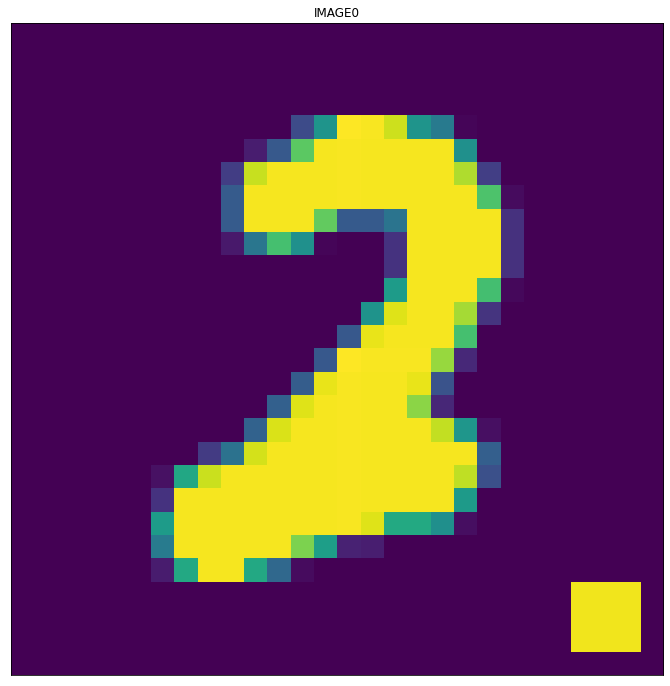

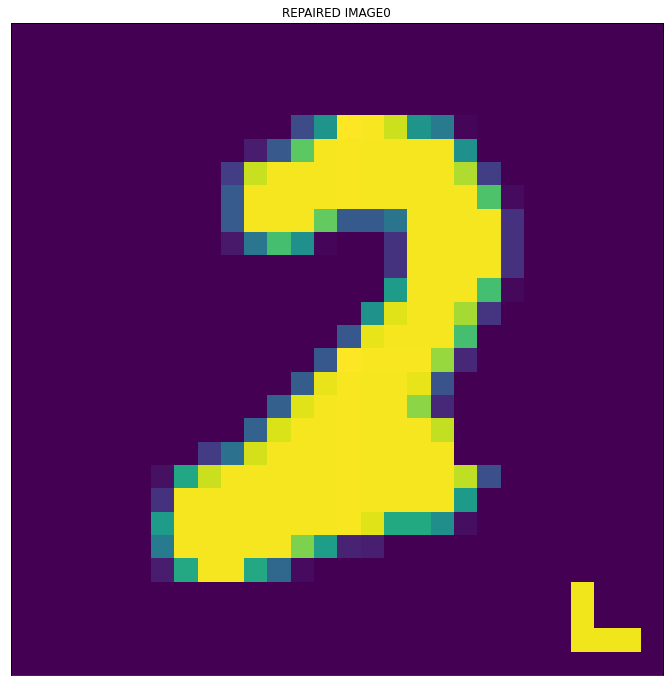

In [17]:
### BASED ON DIFF GRADCAM
import copy
wrongsolve=0
x = copy.deepcopy(gen_data) 
cnt = 0
correct = 0

labels = actuals_gen 
ideals = gen_labels 
start_time = time.time()


test_labels = (model.predict(x)).argmax(axis=1)
PASSA = 0
FAILA = 0
for indx in range(0, firsthalf):
  if (test_labels[indx] == ideals[indx]):
    PASSA = PASSA + 1
  else:
    FAILA = FAILA + 1
print("PASS:", PASSA, ",FAIL:", FAILA,"," ,",CLEAN TEST ACCURACY:", (PASSA/(PASSA+FAILA))*100.0)
PASSB = 0
FAILB = 0
for indx in range(firsthalf, len(x)):
  if (test_labels[indx] == ideals[indx]):
    PASSB = PASSB + 1
  else:
    FAILB = FAILB + 1
print("PASS:", PASSB, ",FAIL:", FAILB,"," ,",Poisoned TEST ACCURACY:", (PASSB/(PASSB+FAILB))*100.0)
print("PASS:", PASSA+PASSB, ",FAIL:", FAILA+FAILB,"," ,",Overall TEST ACCURACY:", ((PASSA+PASSB)/(PASSA+PASSB+FAILA+FAILB))*100.0)

print("--- %s seconds ---" % (time.time() - start_time))





start_time = time.time()

true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0
ss=""

PRINT = True
for inp_cnt in range(0,len(x)): # x is the list of images in the dataset used to extract the mis-classification pattern
    
    image = x[inp_cnt]
    label = labels[inp_cnt]
    
    inp = image 
  
    if (VAL == False):
        inc_layer = 'activation_3'  #layer name, get it from the model summary
        inc_suff = fingerprint_suffix_vals(inp, inc_layer)

        neuron_ids =[]
        inc_neuron_ids=[]
        neuron_sig = []

        for indx in range (0, len(Ainvs_sel_neus)):
          neu_ids = []
          for indx1 in range (0, len(Ainvs_sel_neus[indx])):
              neu_ids.append(-1)
              neu_ids.append(Ainvs_sel_neus[indx][indx1])
          neuron_ids.append(neu_ids)
          inc_neuron_ids.append(Ainvs_sel_neus[indx])

        for indx in range (0, len(Ainvs_sel_sig)):
          neuron_sig.append(Ainvs_sel_sig[indx])

        layer_vals = [] 
        suff = inc_suff
        
    else:
     
        inc_layer = 'activation_3'  #layer name, get it from the model summary
        inc_suff = fingerprint_suffix_vals(inp, inc_layer)

        neuron_ids =[]
        inc_neuron_ids=[]
        neuron_sig = []

        for indx in range (0, len(invs_sel_neus)):
          neu_ids = []
          for indx1 in range (0, len(invs_sel_neus[indx])):
              neu_ids.append(-1)
              neu_ids.append(invs_sel_neus[indx][indx1])
          neuron_ids.append(neu_ids)
          inc_neuron_ids.append(invs_sel_neus[indx])

        for indx in range (0, len(invs_sel_sig)):
          neuron_sig.append(invs_sel_sig[indx])

        layer_vals = inc_suff[0]
        suff = []
  
    image_array = np.zeros((1,28,28,1),dtype=int)
    image_array[0]=image
    
    match = check_pattern_inter(layer_vals,suff,neuron_ids,neuron_sig,VAL,False)
    if (match >= 0):
        

        #print("IDENTIFIED POISONED INPUT", inp_cnt,",", cnt, ",ACTUAL:", labels[inp_cnt], ",IDEAL:", ideals[inp_cnt])
        
        if (inp_cnt>=firsthalf):
          true_positives = true_positives + 1
        else: 
          false_positives = false_positives + 1
        
        if (labels[inp_cnt] == 7 and (labels[inp_cnt] != ideals[inp_cnt]) and PRINT == True and match==0):
                print("BEFORE REPAIR",img.shape,image.shape)
                subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (12, 12),'subplot_kw': {'xticks': [], 'yticks': []} }
                f, ax = plt.subplots(**subplot_args)
                ax.set_title('IMAGE'+str(match))
                norm_img = np.zeros((28,28,1),dtype=float)
                for ix in range(0,28):
                  for iy in range(0,28):
                      norm_img[ix][iy][0] = (image[ix][iy][0])
                img1 = norm_img.reshape(28,28)
                ax.imshow(img1)
                ss=""
                for i in range(0,28):
                  for j in range(0,28):
                      ss=ss+str(image[i][j])+","
                

        image_array = np.zeros((1,28,28,1),dtype=int)
        image_array[0] = image
        label = (model.predict(image_array)).argmax(axis=1)

        #vals=[]
        #for ix in range(0,32):
        #    for iy in range(0,32):
        #        #if (diff_pat[match][0][ix][iy] not in vals):
        #        vals.append(diff_pat[match][0][ix][iy])
           
        #vals.sort(reverse=True)
        #top_10_percent = int((10/100)*(len(vals)))
        #print(len(vals),top_10_percent, vals[top_10_percent])
        #print(vals[top_10_percent])
        #print(diff_pat[match][0])
        #if(true_positives==1):
          #for ix in range(0,32):
            #for iy in range(0,32):
              #if(diff_pat[match][0][ix][iy]>vals[top_10_percent]):
              #print(ix,iy,diff_pat[match][0][ix][iy])
          
        for ix in range(0,28):
            for iy in range(0,28):
                fnd = 0
                for rem in range(0,len(REM2[match])):
                    (rem_ix,rem_iy) = REM2[match][rem]
                    if (rem_ix == ix and rem_iy == iy):
                      image[ix][iy][0]=0
                      fnd = 1
                      break
        #for ix in range(0,32):
        #    for iy in range(0,32):
        #        if (diff_pat[match][0][ix][iy] > vals[top_10_percent] and diff_pat[match][0][ix][iy] > 0.0):
        #          #print(ix,iy)
        #          image[ix][iy][0] = 0
        #          image[ix][iy][1] = 0
        #          image[ix][iy][2] = 0
              
        if (labels[inp_cnt] == 7 and (labels[inp_cnt] != ideals[inp_cnt]) and PRINT == True and match==0):
                PRINT = False
                print("AFTER REPAIR")
                subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (12, 12),'subplot_kw': {'xticks': [], 'yticks': []} }
                f, ax = plt.subplots(**subplot_args)
                ax.set_title('REPAIRED IMAGE'+str(match))
                norm_img = np.zeros((28,28,1),dtype=float)
                for ix in range(0,28):
                  for iy in range(0,28):
                    norm_img[ix][iy][0] = (image[ix][iy][0])
                img1 = norm_img.reshape(28,28)
                ax.imshow(img1)
          
        image_array = np.zeros((1,28,28,1),dtype=int)
        image_array[0]=image
        new_label = (model.predict(image_array)).argmax(axis=1)
        if (labels[inp_cnt] == ideals[inp_cnt] and new_label != ideals[inp_cnt]):
          wrongsolve=wrongsolve+1
        #print("OLD LABEL:", label," ",labels[inp_cnt] ,",REPAIRED LABEL:", new_label, ",CORRECT LABEL:", ideals[inp_cnt])
        if ((ideals[inp_cnt] != label) and (ideals[inp_cnt] == new_label)):
            correct = correct + 1
        cnt = cnt + 1    
    else:
      if (inp_cnt>=firsthalf):
          false_negatives = false_negatives + 1
      else: 
          true_negatives = true_negatives + 1
        

print('CNT:',cnt)

print('TP:', true_positives, ',FP:', false_positives, ",TN:", true_negatives, ",FN:", false_negatives)
PREC = ((true_positives)/ (true_positives + false_positives))
RECALL = ((true_positives)/ (true_positives + false_negatives))
print("PRECISION:" , PREC * 100.0, ",RECALL:", RECALL * 100.0)

print('CORRECT:', correct)
rep_rate = ((correct/true_positives) * 100.0)
print("REPAIR RATE:", rep_rate)
print(ss)
print("--- %s seconds ---" % (time.time() - start_time))


start_time = time.time()

test_labels = (model.predict(x)).argmax(axis=1)
PASSA = 0
FAILA = 0
for indx in range(0, firsthalf):
  if (test_labels[indx] == ideals[indx]):
    PASSA = PASSA + 1
  else:
    FAILA = FAILA + 1
print("PASS:", PASSA, ",FAIL:", FAILA,"," ,",CLEAN TEST ACCURACY:", (PASSA/(PASSA+FAILA))*100.0)
PASSB = 0
FAILB = 0
for indx in range(firsthalf, len(x)):
  if (test_labels[indx] == ideals[indx]):
    PASSB = PASSB + 1
  else:
    FAILB = FAILB + 1
print("PASS:", PASSB, ",FAIL:", FAILB,"," ,",Poisoned TEST ACCURACY:", (PASSB/(PASSB+FAILB))*100.0)
print("PASS:", PASSA+PASSB, ",FAIL:", FAILA+FAILB,"," ,",Overall TEST ACCURACY:", ((PASSA+PASSB)/(PASSA+PASSB+FAILA+FAILB))*100.0)

print("--- %s seconds ---" % (time.time() - start_time))



PASS: 4932 ,FAIL: 68 , ,CLEAN TEST ACCURACY: 98.64
PASS: 6 ,FAIL: 44 , ,Poisoned TEST ACCURACY: 12.0
PASS: 4938 ,FAIL: 112 , ,Overall TEST ACCURACY: 97.78217821782178
--- 1.0334582328796387 seconds ---
BEFORE REPAIR (28, 28, 1) (28, 28, 1)
AFTER REPAIR
CNT: 55
TP: 44 ,FP: 11 ,TN: 4989 ,FN: 6
PRECISION: 80.0 ,RECALL: 88.0
CORRECT: 5
REPAIR RATE: 11.363636363636363
[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[58],[132],[255],[253],[236],[132],[105],[3],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[20],[71],[191],[252]

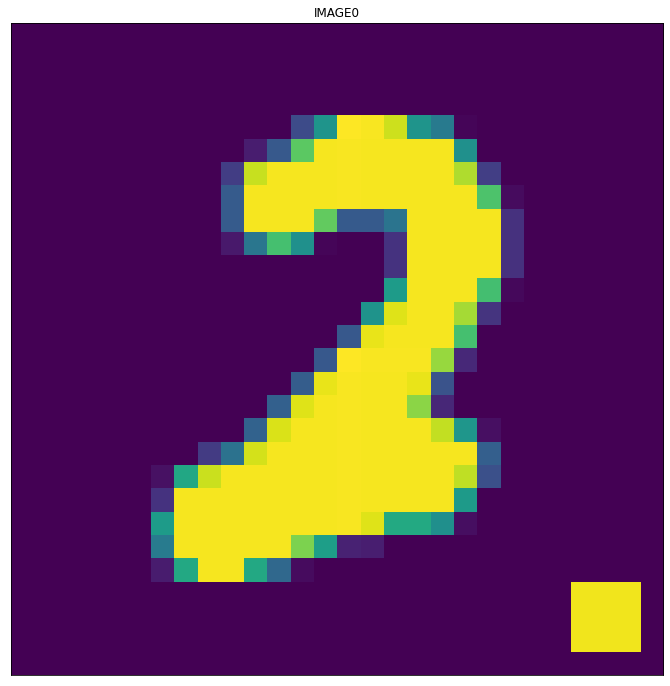

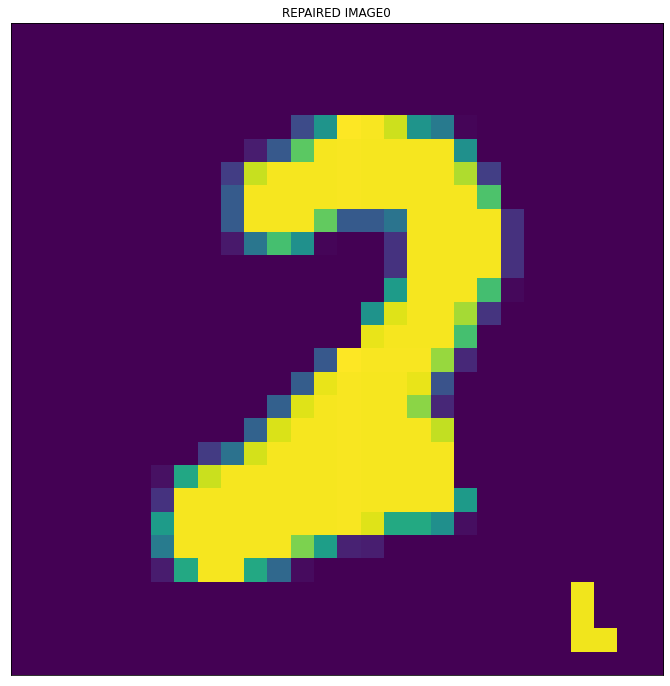

In [18]:
### BASED ON DIFF GRADCAM
import copy
wrongsolve=0
x = copy.deepcopy(gen_data) 
cnt = 0
correct = 0

labels = actuals_gen 
ideals = gen_labels 
start_time = time.time()

test_labels = (model.predict(x)).argmax(axis=1)
PASSA = 0
FAILA = 0
for indx in range(0, firsthalf):
  if (test_labels[indx] == ideals[indx]):
    PASSA = PASSA + 1
  else:
    FAILA = FAILA + 1
print("PASS:", PASSA, ",FAIL:", FAILA,"," ,",CLEAN TEST ACCURACY:", (PASSA/(PASSA+FAILA))*100.0)
PASSB = 0
FAILB = 0
for indx in range(firsthalf, len(x)):
  if (test_labels[indx] == ideals[indx]):
    PASSB = PASSB + 1
  else:
    FAILB = FAILB + 1
print("PASS:", PASSB, ",FAIL:", FAILB,"," ,",Poisoned TEST ACCURACY:", (PASSB/(PASSB+FAILB))*100.0)
print("PASS:", PASSA+PASSB, ",FAIL:", FAILA+FAILB,"," ,",Overall TEST ACCURACY:", ((PASSA+PASSB)/(PASSA+PASSB+FAILA+FAILB))*100.0)

print("--- %s seconds ---" % (time.time() - start_time))





start_time = time.time()

true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0
ss=""

PRINT = True
for inp_cnt in range(0,len(x)): # x is the list of images in the dataset used to extract the mis-classification pattern
    
    image = x[inp_cnt]
    label = labels[inp_cnt]
    
    inp = image 
  
    if (VAL == False):
        inc_layer = 'activation_3'  #layer name, get it from the model summary
        inc_suff = fingerprint_suffix_vals(inp, inc_layer)

        neuron_ids =[]
        inc_neuron_ids=[]
        neuron_sig = []

        for indx in range (0, len(Ainvs_sel_neus)):
          neu_ids = []
          for indx1 in range (0, len(Ainvs_sel_neus[indx])):
              neu_ids.append(-1)
              neu_ids.append(Ainvs_sel_neus[indx][indx1])
          neuron_ids.append(neu_ids)
          inc_neuron_ids.append(Ainvs_sel_neus[indx])

        for indx in range (0, len(Ainvs_sel_sig)):
          neuron_sig.append(Ainvs_sel_sig[indx])

        layer_vals = [] 
        suff = inc_suff
        
    else:
     
        inc_layer = 'activation_3'  #layer name, get it from the model summary
        inc_suff = fingerprint_suffix_vals(inp, inc_layer)

        neuron_ids =[]
        inc_neuron_ids=[]
        neuron_sig = []

        for indx in range (0, len(invs_sel_neus)):
          neu_ids = []
          for indx1 in range (0, len(invs_sel_neus[indx])):
              neu_ids.append(-1)
              neu_ids.append(invs_sel_neus[indx][indx1])
          neuron_ids.append(neu_ids)
          inc_neuron_ids.append(invs_sel_neus[indx])

        for indx in range (0, len(invs_sel_sig)):
          neuron_sig.append(invs_sel_sig[indx])

        layer_vals = inc_suff[0]
        suff = []
  
    image_array = np.zeros((1,28,28,1),dtype=int)
    image_array[0]=image
    
    match = check_pattern_inter(layer_vals,suff,neuron_ids,neuron_sig,VAL,False)
    if (match >= 0):
        

        #print("IDENTIFIED POISONED INPUT", inp_cnt,",", cnt, ",ACTUAL:", labels[inp_cnt], ",IDEAL:", ideals[inp_cnt])
        
        if (inp_cnt>=firsthalf):
          true_positives = true_positives + 1
        else: 
          false_positives = false_positives + 1
        
        if (labels[inp_cnt] == 7 and (labels[inp_cnt] != ideals[inp_cnt]) and PRINT == True and match==0):
                print("BEFORE REPAIR",img.shape,image.shape)
                subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (12, 12),'subplot_kw': {'xticks': [], 'yticks': []} }
                f, ax = plt.subplots(**subplot_args)
                ax.set_title('IMAGE'+str(match))
                norm_img = np.zeros((28,28,1),dtype=float)
                for ix in range(0,28):
                  for iy in range(0,28):
                      norm_img[ix][iy][0] = (image[ix][iy][0])
                img1 = norm_img.reshape(28,28)
                ax.imshow(img1)
                ss=""
                for i in range(0,28):
                  for j in range(0,28):
                      ss=ss+str(image[i][j])+","
                

        image_array = np.zeros((1,28,28,1),dtype=int)
        image_array[0] = image
        label = (model.predict(image_array)).argmax(axis=1)

        #vals=[]
        #for ix in range(0,32):
        #    for iy in range(0,32):
        #        #if (diff_pat[match][0][ix][iy] not in vals):
        #        vals.append(diff_pat[match][0][ix][iy])
           
        #vals.sort(reverse=True)
        #top_10_percent = int((10/100)*(len(vals)))
        #print(len(vals),top_10_percent, vals[top_10_percent])
        #print(vals[top_10_percent])
        #print(diff_pat[match][0])
        #if(true_positives==1):
          #for ix in range(0,32):
            #for iy in range(0,32):
              #if(diff_pat[match][0][ix][iy]>vals[top_10_percent]):
              #print(ix,iy,diff_pat[match][0][ix][iy])
          
        for ix in range(0,28):
            for iy in range(0,28):
                fnd = 0
                for rem in range(0,len(REM5[match])):
                    (rem_ix,rem_iy) = REM5[match][rem]
                    if (rem_ix == ix and rem_iy == iy):
                      image[ix][iy][0]=0
                      fnd = 1
                      break
        #for ix in range(0,32):
        #    for iy in range(0,32):
        #        if (diff_pat[match][0][ix][iy] > vals[top_10_percent] and diff_pat[match][0][ix][iy] > 0.0):
        #          #print(ix,iy)
        #          image[ix][iy][0] = 0
        #          image[ix][iy][1] = 0
        #          image[ix][iy][2] = 0
              
        if (labels[inp_cnt] == 7 and (labels[inp_cnt] != ideals[inp_cnt]) and PRINT == True and match==0):
                PRINT = False
                print("AFTER REPAIR")
                subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (12, 12),'subplot_kw': {'xticks': [], 'yticks': []} }
                f, ax = plt.subplots(**subplot_args)
                ax.set_title('REPAIRED IMAGE'+str(match))
                norm_img = np.zeros((28,28,1),dtype=float)
                for ix in range(0,28):
                  for iy in range(0,28):
                    norm_img[ix][iy][0] = (image[ix][iy][0])
                img1 = norm_img.reshape(28,28)
                ax.imshow(img1)
          
        image_array = np.zeros((1,28,28,1),dtype=int)
        image_array[0]=image
        new_label = (model.predict(image_array)).argmax(axis=1)
        if (labels[inp_cnt] == ideals[inp_cnt] and new_label != ideals[inp_cnt]):
          wrongsolve=wrongsolve+1
        #print("OLD LABEL:", label," ",labels[inp_cnt] ,",REPAIRED LABEL:", new_label, ",CORRECT LABEL:", ideals[inp_cnt])
        if ((ideals[inp_cnt] != label) and (ideals[inp_cnt] == new_label)):
            correct = correct + 1
        cnt = cnt + 1    
    else:
      if (inp_cnt>=firsthalf):
          false_negatives = false_negatives + 1
      else: 
          true_negatives = true_negatives + 1
        

print('CNT:',cnt)

print('TP:', true_positives, ',FP:', false_positives, ",TN:", true_negatives, ",FN:", false_negatives)
PREC = ((true_positives)/ (true_positives + false_positives))
RECALL = ((true_positives)/ (true_positives + false_negatives))
print("PRECISION:" , PREC * 100.0, ",RECALL:", RECALL * 100.0)

print('CORRECT:', correct)
rep_rate = ((correct/true_positives) * 100.0)
print("REPAIR RATE:", rep_rate)
print(ss)
print("--- %s seconds ---" % (time.time() - start_time))


start_time = time.time()

test_labels = (model.predict(x)).argmax(axis=1)
PASSA = 0
FAILA = 0
for indx in range(0, firsthalf):
  if (test_labels[indx] == ideals[indx]):
    PASSA = PASSA + 1
  else:
    FAILA = FAILA + 1
print("PASS:", PASSA, ",FAIL:", FAILA,"," ,",CLEAN TEST ACCURACY:", (PASSA/(PASSA+FAILA))*100.0)
PASSB = 0
FAILB = 0
for indx in range(firsthalf, len(x)):
  if (test_labels[indx] == ideals[indx]):
    PASSB = PASSB + 1
  else:
    FAILB = FAILB + 1
print("PASS:", PASSB, ",FAIL:", FAILB,"," ,",Poisoned TEST ACCURACY:", (PASSB/(PASSB+FAILB))*100.0)
print("PASS:", PASSA+PASSB, ",FAIL:", FAILA+FAILB,"," ,",Overall TEST ACCURACY:", ((PASSA+PASSB)/(PASSA+PASSB+FAILA+FAILB))*100.0)

print("--- %s seconds ---" % (time.time() - start_time))



PASS: 4932 ,FAIL: 68 , ,CLEAN TEST ACCURACY: 98.64
PASS: 6 ,FAIL: 44 , ,Poisoned TEST ACCURACY: 12.0
PASS: 4938 ,FAIL: 112 , ,Overall TEST ACCURACY: 97.78217821782178
--- 1.0395009517669678 seconds ---
BEFORE REPAIR (28, 28, 1) (28, 28, 1)
AFTER REPAIR
CNT: 55
TP: 44 ,FP: 11 ,TN: 4989 ,FN: 6
PRECISION: 80.0 ,RECALL: 88.0
CORRECT: 21
REPAIR RATE: 47.72727272727273
[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[58],[132],[255],[253],[236],[132],[105],[3],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[20],[71],[191],[252]

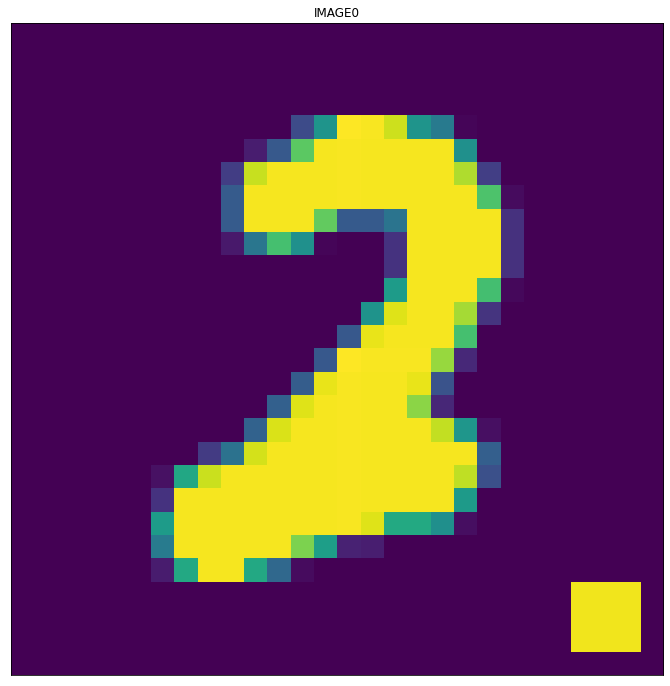

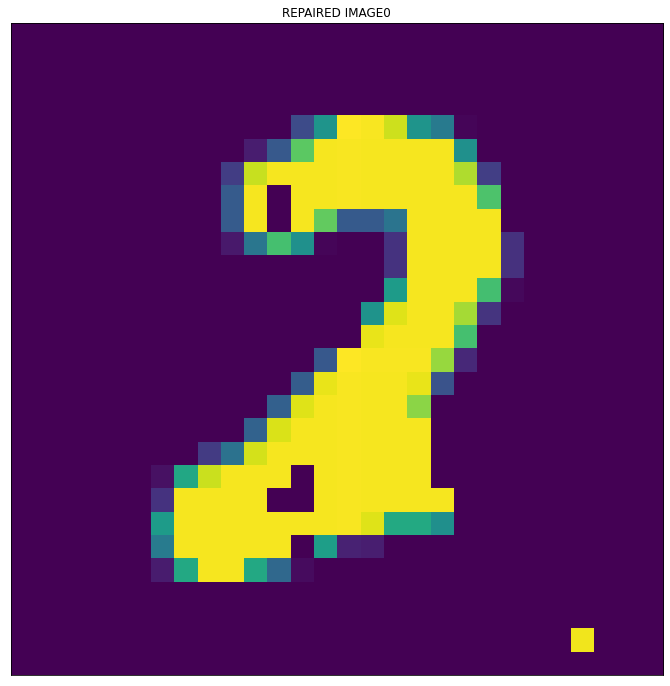

In [19]:
### BASED ON DIFF GRADCAM
import copy
wrongsolve=0
x = copy.deepcopy(gen_data) 
cnt = 0
correct = 0

labels = actuals_gen 
ideals = gen_labels 
start_time = time.time()

test_labels = (model.predict(x)).argmax(axis=1)
PASSA = 0
FAILA = 0
for indx in range(0, firsthalf):
  if (test_labels[indx] == ideals[indx]):
    PASSA = PASSA + 1
  else:
    FAILA = FAILA + 1
print("PASS:", PASSA, ",FAIL:", FAILA,"," ,",CLEAN TEST ACCURACY:", (PASSA/(PASSA+FAILA))*100.0)
PASSB = 0
FAILB = 0
for indx in range(firsthalf, len(x)):
  if (test_labels[indx] == ideals[indx]):
    PASSB = PASSB + 1
  else:
    FAILB = FAILB + 1
print("PASS:", PASSB, ",FAIL:", FAILB,"," ,",Poisoned TEST ACCURACY:", (PASSB/(PASSB+FAILB))*100.0)
print("PASS:", PASSA+PASSB, ",FAIL:", FAILA+FAILB,"," ,",Overall TEST ACCURACY:", ((PASSA+PASSB)/(PASSA+PASSB+FAILA+FAILB))*100.0)

print("--- %s seconds ---" % (time.time() - start_time))





start_time = time.time()

true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0
ss=""

PRINT = True
for inp_cnt in range(0,len(x)): # x is the list of images in the dataset used to extract the mis-classification pattern
    
    image = x[inp_cnt]
    label = labels[inp_cnt]
    
    inp = image 
  
    if (VAL == False):
        inc_layer = 'activation_3'  #layer name, get it from the model summary
        inc_suff = fingerprint_suffix_vals(inp, inc_layer)

        neuron_ids =[]
        inc_neuron_ids=[]
        neuron_sig = []

        for indx in range (0, len(Ainvs_sel_neus)):
          neu_ids = []
          for indx1 in range (0, len(Ainvs_sel_neus[indx])):
              neu_ids.append(-1)
              neu_ids.append(Ainvs_sel_neus[indx][indx1])
          neuron_ids.append(neu_ids)
          inc_neuron_ids.append(Ainvs_sel_neus[indx])

        for indx in range (0, len(Ainvs_sel_sig)):
          neuron_sig.append(Ainvs_sel_sig[indx])

        layer_vals = [] 
        suff = inc_suff
        
    else:
     
        inc_layer = 'activation_3'  #layer name, get it from the model summary
        inc_suff = fingerprint_suffix_vals(inp, inc_layer)

        neuron_ids =[]
        inc_neuron_ids=[]
        neuron_sig = []

        for indx in range (0, len(invs_sel_neus)):
          neu_ids = []
          for indx1 in range (0, len(invs_sel_neus[indx])):
              neu_ids.append(-1)
              neu_ids.append(invs_sel_neus[indx][indx1])
          neuron_ids.append(neu_ids)
          inc_neuron_ids.append(invs_sel_neus[indx])

        for indx in range (0, len(invs_sel_sig)):
          neuron_sig.append(invs_sel_sig[indx])

        layer_vals = inc_suff[0]
        suff = []
  
    image_array = np.zeros((1,28,28,1),dtype=int)
    image_array[0]=image
    
    match = check_pattern_inter(layer_vals,suff,neuron_ids,neuron_sig,VAL,False)
    if (match >= 0):
        

        #print("IDENTIFIED POISONED INPUT", inp_cnt,",", cnt, ",ACTUAL:", labels[inp_cnt], ",IDEAL:", ideals[inp_cnt])
        
        if (inp_cnt>=firsthalf):
          true_positives = true_positives + 1
        else: 
          false_positives = false_positives + 1
        
        if (labels[inp_cnt] == 7 and (labels[inp_cnt] != ideals[inp_cnt]) and PRINT == True and match==0):
                print("BEFORE REPAIR",img.shape,image.shape)
                subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (12, 12),'subplot_kw': {'xticks': [], 'yticks': []} }
                f, ax = plt.subplots(**subplot_args)
                ax.set_title('IMAGE'+str(match))
                norm_img = np.zeros((28,28,1),dtype=float)
                for ix in range(0,28):
                  for iy in range(0,28):
                      norm_img[ix][iy][0] = (image[ix][iy][0])
                img1 = norm_img.reshape(28,28)
                ax.imshow(img1)
                ss=""
                for i in range(0,28):
                  for j in range(0,28):
                      ss=ss+str(image[i][j])+","
                

        image_array = np.zeros((1,28,28,1),dtype=int)
        image_array[0] = image
        label = (model.predict(image_array)).argmax(axis=1)

        #vals=[]
        #for ix in range(0,32):
        #    for iy in range(0,32):
        #        #if (diff_pat[match][0][ix][iy] not in vals):
        #        vals.append(diff_pat[match][0][ix][iy])
           
        #vals.sort(reverse=True)
        #top_10_percent = int((10/100)*(len(vals)))
        #print(len(vals),top_10_percent, vals[top_10_percent])
        #print(vals[top_10_percent])
        #print(diff_pat[match][0])
        #if(true_positives==1):
          #for ix in range(0,32):
            #for iy in range(0,32):
              #if(diff_pat[match][0][ix][iy]>vals[top_10_percent]):
              #print(ix,iy,diff_pat[match][0][ix][iy])
          
        for ix in range(0,28):
            for iy in range(0,28):
                fnd = 0
                for rem in range(0,len(REM10[match])):
                    (rem_ix,rem_iy) = REM10[match][rem]
                    if (rem_ix == ix and rem_iy == iy):
                      image[ix][iy][0]=0
                      fnd = 1
                      break
        #for ix in range(0,32):
        #    for iy in range(0,32):
        #        if (diff_pat[match][0][ix][iy] > vals[top_10_percent] and diff_pat[match][0][ix][iy] > 0.0):
        #          #print(ix,iy)
        #          image[ix][iy][0] = 0
        #          image[ix][iy][1] = 0
        #          image[ix][iy][2] = 0
              
        if (labels[inp_cnt] == 7 and (labels[inp_cnt] != ideals[inp_cnt]) and PRINT == True and match==0):
                PRINT = False
                print("AFTER REPAIR")
                subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (12, 12),'subplot_kw': {'xticks': [], 'yticks': []} }
                f, ax = plt.subplots(**subplot_args)
                ax.set_title('REPAIRED IMAGE'+str(match))
                norm_img = np.zeros((28,28,1),dtype=float)
                for ix in range(0,28):
                  for iy in range(0,28):
                    norm_img[ix][iy][0] = (image[ix][iy][0])
                img1 = norm_img.reshape(28,28)
                ax.imshow(img1)
          
        image_array = np.zeros((1,28,28,1),dtype=int)
        image_array[0]=image
        new_label = (model.predict(image_array)).argmax(axis=1)
        if (labels[inp_cnt] == ideals[inp_cnt] and new_label != ideals[inp_cnt]):
          wrongsolve=wrongsolve+1
        #print("OLD LABEL:", label," ",labels[inp_cnt] ,",REPAIRED LABEL:", new_label, ",CORRECT LABEL:", ideals[inp_cnt])
        if ((ideals[inp_cnt] != label) and (ideals[inp_cnt] == new_label)):
            correct = correct + 1
        cnt = cnt + 1    
    else:
      if (inp_cnt>=firsthalf):
          false_negatives = false_negatives + 1
      else: 
          true_negatives = true_negatives + 1
        

print('CNT:',cnt)

print('TP:', true_positives, ',FP:', false_positives, ",TN:", true_negatives, ",FN:", false_negatives)
PREC = ((true_positives)/ (true_positives + false_positives))
RECALL = ((true_positives)/ (true_positives + false_negatives))
print("PRECISION:" , PREC * 100.0, ",RECALL:", RECALL * 100.0)

print('CORRECT:', correct)
rep_rate = ((correct/true_positives) * 100.0)
print("REPAIR RATE:", rep_rate)
print(ss)
print("--- %s seconds ---" % (time.time() - start_time))


start_time = time.time()

test_labels = (model.predict(x)).argmax(axis=1)
PASSA = 0
FAILA = 0
for indx in range(0, firsthalf):
  if (test_labels[indx] == ideals[indx]):
    PASSA = PASSA + 1
  else:
    FAILA = FAILA + 1
print("PASS:", PASSA, ",FAIL:", FAILA,"," ,",CLEAN TEST ACCURACY:", (PASSA/(PASSA+FAILA))*100.0)
PASSB = 0
FAILB = 0
for indx in range(firsthalf, len(x)):
  if (test_labels[indx] == ideals[indx]):
    PASSB = PASSB + 1
  else:
    FAILB = FAILB + 1
print("PASS:", PASSB, ",FAIL:", FAILB,"," ,",Poisoned TEST ACCURACY:", (PASSB/(PASSB+FAILB))*100.0)
print("PASS:", PASSA+PASSB, ",FAIL:", FAILA+FAILB,"," ,",Overall TEST ACCURACY:", ((PASSA+PASSB)/(PASSA+PASSB+FAILA+FAILB))*100.0)

print("--- %s seconds ---" % (time.time() - start_time))



PASS: 4931 ,FAIL: 69 , ,CLEAN TEST ACCURACY: 98.61999999999999
PASS: 533 ,FAIL: 4467 , ,Poisoned TEST ACCURACY: 10.66
PASS: 5464 ,FAIL: 4536 , ,Overall TEST ACCURACY: 54.64
--- 2.012617349624634 seconds ---
BEFORE REPAIR (28, 28, 1) (28, 28, 1)
AFTER REPAIR
CNT: 2139
TP: 2112 ,FP: 27 ,TN: 4973 ,FN: 2888
PRECISION: 98.73772791023842 ,RECALL: 42.24
CORRECT: 22
REPAIR RATE: 1.0416666666666665
[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[11],[150],[253],[202],[31],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]

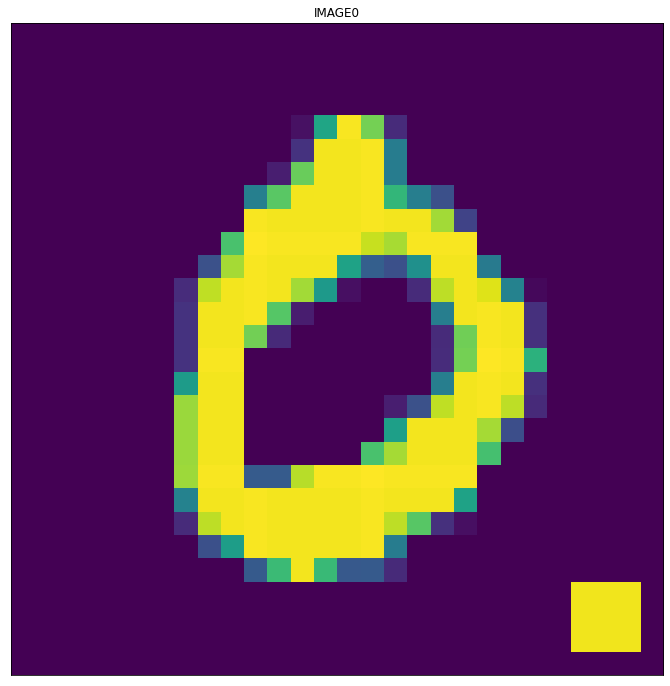

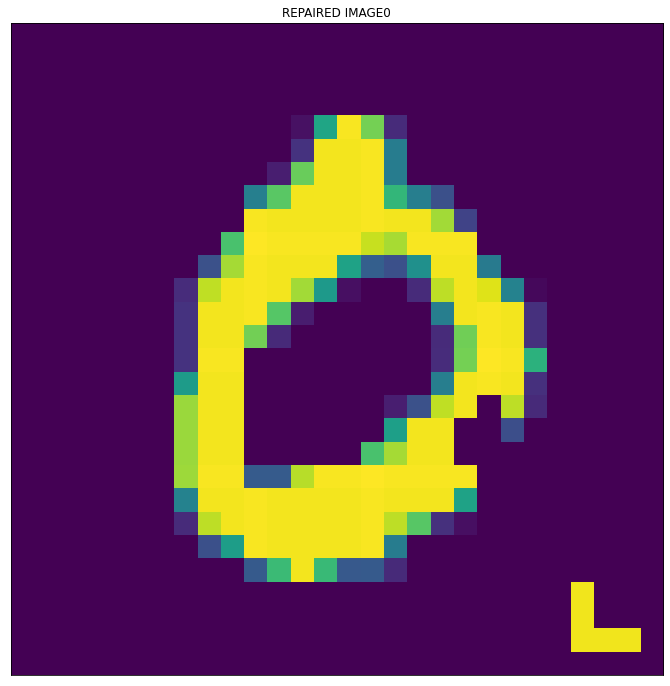

In [20]:
### BASED ON DIFF GRADCAM
import copy
wrongsolve=0
x = copy.deepcopy(val_data) 
cnt = 0
correct = 0

labels = actuals_val 
ideals = val_labels 
start_time = time.time()


test_labels = (model.predict(x)).argmax(axis=1)
PASSA = 0
FAILA = 0
for indx in range(0, firsthalf):
  if (test_labels[indx] == ideals[indx]):
    PASSA = PASSA + 1
  else:
    FAILA = FAILA + 1
print("PASS:", PASSA, ",FAIL:", FAILA,"," ,",CLEAN TEST ACCURACY:", (PASSA/(PASSA+FAILA))*100.0)
PASSB = 0
FAILB = 0
for indx in range(firsthalf, len(x)):
  if (test_labels[indx] == ideals[indx]):
    PASSB = PASSB + 1
  else:
    FAILB = FAILB + 1
print("PASS:", PASSB, ",FAIL:", FAILB,"," ,",Poisoned TEST ACCURACY:", (PASSB/(PASSB+FAILB))*100.0)
print("PASS:", PASSA+PASSB, ",FAIL:", FAILA+FAILB,"," ,",Overall TEST ACCURACY:", ((PASSA+PASSB)/(PASSA+PASSB+FAILA+FAILB))*100.0)

print("--- %s seconds ---" % (time.time() - start_time))





start_time = time.time()

true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0
ss=""

PRINT = True
for inp_cnt in range(0,len(x)): # x is the list of images in the dataset used to extract the mis-classification pattern
    
    image = x[inp_cnt]
    label = labels[inp_cnt]
    
    inp = image 
  
    if (VAL == False):
        inc_layer = 'activation_3'  #layer name, get it from the model summary
        inc_suff = fingerprint_suffix_vals(inp, inc_layer)

        neuron_ids =[]
        inc_neuron_ids=[]
        neuron_sig = []

        for indx in range (0, len(Ainvs_sel_neus)):
          neu_ids = []
          for indx1 in range (0, len(Ainvs_sel_neus[indx])):
              neu_ids.append(-1)
              neu_ids.append(Ainvs_sel_neus[indx][indx1])
          neuron_ids.append(neu_ids)
          inc_neuron_ids.append(Ainvs_sel_neus[indx])

        for indx in range (0, len(Ainvs_sel_sig)):
          neuron_sig.append(Ainvs_sel_sig[indx])

        layer_vals = [] 
        suff = inc_suff
        
    else:
     
        inc_layer = 'activation_3'  #layer name, get it from the model summary
        inc_suff = fingerprint_suffix_vals(inp, inc_layer)

        neuron_ids =[]
        inc_neuron_ids=[]
        neuron_sig = []

        for indx in range (0, len(invs_sel_neus)):
          neu_ids = []
          for indx1 in range (0, len(invs_sel_neus[indx])):
              neu_ids.append(-1)
              neu_ids.append(invs_sel_neus[indx][indx1])
          neuron_ids.append(neu_ids)
          inc_neuron_ids.append(invs_sel_neus[indx])

        for indx in range (0, len(invs_sel_sig)):
          neuron_sig.append(invs_sel_sig[indx])

        layer_vals = inc_suff[0]
        suff = []
  
    image_array = np.zeros((1,28,28,1),dtype=int)
    image_array[0]=image
    
    match = check_pattern_inter(layer_vals,suff,neuron_ids,neuron_sig,VAL,False)
    if (match >= 0):
        

        #print("IDENTIFIED POISONED INPUT", inp_cnt,",", cnt, ",ACTUAL:", labels[inp_cnt], ",IDEAL:", ideals[inp_cnt])
        
        if (inp_cnt>=firsthalf):
          true_positives = true_positives + 1
        else: 
          false_positives = false_positives + 1
        
        if (labels[inp_cnt] == 7 and (labels[inp_cnt] != ideals[inp_cnt]) and PRINT == True and match==0):
                print("BEFORE REPAIR",img.shape,image.shape)
                subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (12, 12),'subplot_kw': {'xticks': [], 'yticks': []} }
                f, ax = plt.subplots(**subplot_args)
                ax.set_title('IMAGE'+str(match))
                norm_img = np.zeros((28,28,1),dtype=float)
                for ix in range(0,28):
                  for iy in range(0,28):
                      norm_img[ix][iy][0] = (image[ix][iy][0])
                img1 = norm_img.reshape(28,28)
                ax.imshow(img1)
                ss=""
                for i in range(0,28):
                  for j in range(0,28):
                      ss=ss+str(image[i][j])+","
                

        image_array = np.zeros((1,28,28,1),dtype=int)
        image_array[0] = image
        label = (model.predict(image_array)).argmax(axis=1)

        #vals=[]
        #for ix in range(0,32):
        #    for iy in range(0,32):
        #        #if (diff_pat[match][0][ix][iy] not in vals):
        #        vals.append(diff_pat[match][0][ix][iy])
           
        #vals.sort(reverse=True)
        #top_10_percent = int((10/100)*(len(vals)))
        #print(len(vals),top_10_percent, vals[top_10_percent])
        #print(vals[top_10_percent])
        #print(diff_pat[match][0])
        #if(true_positives==1):
          #for ix in range(0,32):
            #for iy in range(0,32):
              #if(diff_pat[match][0][ix][iy]>vals[top_10_percent]):
              #print(ix,iy,diff_pat[match][0][ix][iy])
          
        for ix in range(0,28):
            for iy in range(0,28):
                fnd = 0
                for rem in range(0,len(REM2[match])):
                    (rem_ix,rem_iy) = REM2[match][rem]
                    if (rem_ix == ix and rem_iy == iy):
                      image[ix][iy][0]=0
                      fnd = 1
                      break
        #for ix in range(0,32):
        #    for iy in range(0,32):
        #        if (diff_pat[match][0][ix][iy] > vals[top_10_percent] and diff_pat[match][0][ix][iy] > 0.0):
        #          #print(ix,iy)
        #          image[ix][iy][0] = 0
        #          image[ix][iy][1] = 0
        #          image[ix][iy][2] = 0
              
        if (labels[inp_cnt] == 7 and (labels[inp_cnt] != ideals[inp_cnt]) and PRINT == True and match==0):
                PRINT = False
                print("AFTER REPAIR")
                subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (12, 12),'subplot_kw': {'xticks': [], 'yticks': []} }
                f, ax = plt.subplots(**subplot_args)
                ax.set_title('REPAIRED IMAGE'+str(match))
                norm_img = np.zeros((28,28,1),dtype=float)
                for ix in range(0,28):
                  for iy in range(0,28):
                    norm_img[ix][iy][0] = (image[ix][iy][0])
                img1 = norm_img.reshape(28,28)
                ax.imshow(img1)
          
        image_array = np.zeros((1,28,28,1),dtype=int)
        image_array[0]=image
        new_label = (model.predict(image_array)).argmax(axis=1)
        if (labels[inp_cnt] == ideals[inp_cnt] and new_label != ideals[inp_cnt]):
          wrongsolve=wrongsolve+1
        #print("OLD LABEL:", label," ",labels[inp_cnt] ,",REPAIRED LABEL:", new_label, ",CORRECT LABEL:", ideals[inp_cnt])
        if ((ideals[inp_cnt] != label) and (ideals[inp_cnt] == new_label)):
            correct = correct + 1
        cnt = cnt + 1    
    else:
      if (inp_cnt>=firsthalf):
          false_negatives = false_negatives + 1
      else: 
          true_negatives = true_negatives + 1
        

print('CNT:',cnt)

print('TP:', true_positives, ',FP:', false_positives, ",TN:", true_negatives, ",FN:", false_negatives)
PREC = ((true_positives)/ (true_positives + false_positives))
RECALL = ((true_positives)/ (true_positives + false_negatives))
print("PRECISION:" , PREC * 100.0, ",RECALL:", RECALL * 100.0)

print('CORRECT:', correct)
rep_rate = ((correct/true_positives) * 100.0)
print("REPAIR RATE:", rep_rate)
print(ss)
print("--- %s seconds ---" % (time.time() - start_time))


start_time = time.time()

test_labels = (model.predict(x)).argmax(axis=1)
PASSA = 0
FAILA = 0
for indx in range(0, firsthalf):
  if (test_labels[indx] == ideals[indx]):
    PASSA = PASSA + 1
  else:
    FAILA = FAILA + 1
print("PASS:", PASSA, ",FAIL:", FAILA,"," ,",CLEAN TEST ACCURACY:", (PASSA/(PASSA+FAILA))*100.0)
PASSB = 0
FAILB = 0
for indx in range(firsthalf, len(x)):
  if (test_labels[indx] == ideals[indx]):
    PASSB = PASSB + 1
  else:
    FAILB = FAILB + 1
print("PASS:", PASSB, ",FAIL:", FAILB,"," ,",Poisoned TEST ACCURACY:", (PASSB/(PASSB+FAILB))*100.0)
print("PASS:", PASSA+PASSB, ",FAIL:", FAILA+FAILB,"," ,",Overall TEST ACCURACY:", ((PASSA+PASSB)/(PASSA+PASSB+FAILA+FAILB))*100.0)

print("--- %s seconds ---" % (time.time() - start_time))



PASS: 4931 ,FAIL: 69 , ,CLEAN TEST ACCURACY: 98.61999999999999
PASS: 533 ,FAIL: 4467 , ,Poisoned TEST ACCURACY: 10.66
PASS: 5464 ,FAIL: 4536 , ,Overall TEST ACCURACY: 54.64
--- 1.8129448890686035 seconds ---
BEFORE REPAIR (28, 28, 1) (28, 28, 1)
AFTER REPAIR
CNT: 2139
TP: 2112 ,FP: 27 ,TN: 4973 ,FN: 2888
PRECISION: 98.73772791023842 ,RECALL: 42.24
CORRECT: 121
REPAIR RATE: 5.729166666666666
[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[11],[150],[253],[202],[31],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0

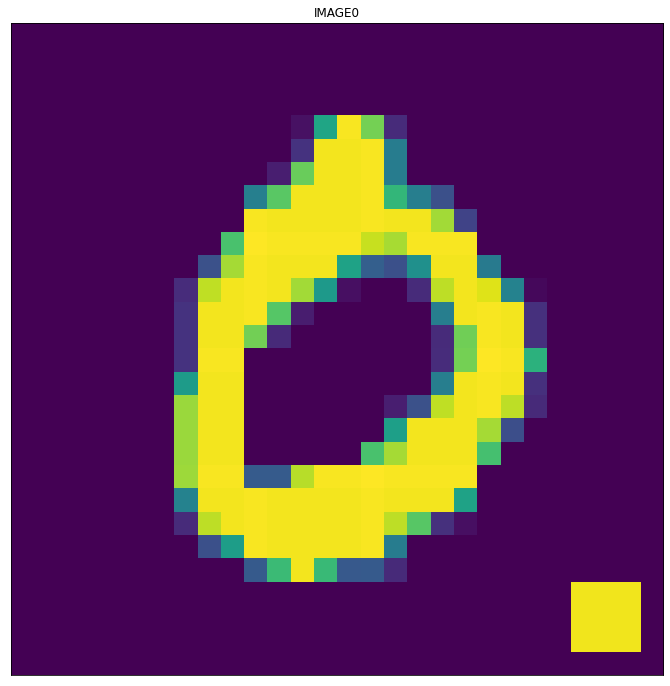

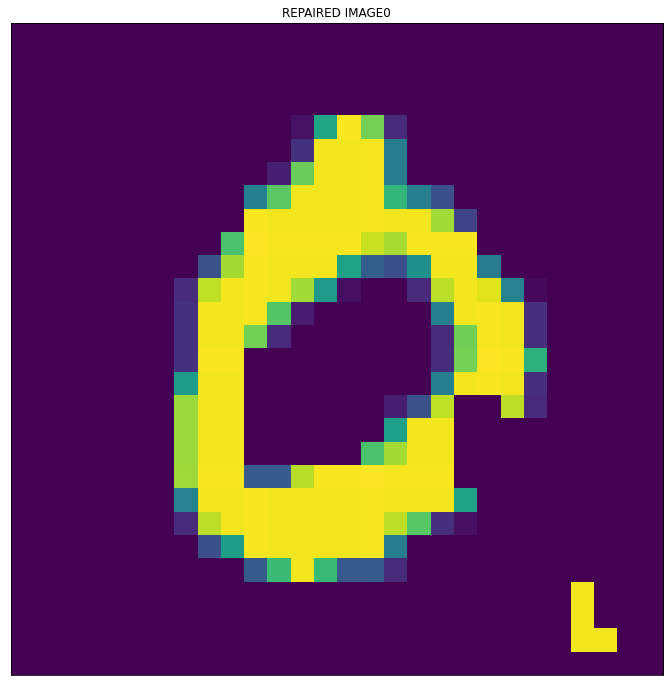

In [21]:
### BASED ON DIFF GRADCAM
import copy
wrongsolve=0
x = copy.deepcopy(val_data) 
cnt = 0
correct = 0

labels = actuals_val 
ideals = val_labels 
start_time = time.time()


test_labels = (model.predict(x)).argmax(axis=1)
PASSA = 0
FAILA = 0
for indx in range(0, firsthalf):
  if (test_labels[indx] == ideals[indx]):
    PASSA = PASSA + 1
  else:
    FAILA = FAILA + 1
print("PASS:", PASSA, ",FAIL:", FAILA,"," ,",CLEAN TEST ACCURACY:", (PASSA/(PASSA+FAILA))*100.0)
PASSB = 0
FAILB = 0
for indx in range(firsthalf, len(x)):
  if (test_labels[indx] == ideals[indx]):
    PASSB = PASSB + 1
  else:
    FAILB = FAILB + 1
print("PASS:", PASSB, ",FAIL:", FAILB,"," ,",Poisoned TEST ACCURACY:", (PASSB/(PASSB+FAILB))*100.0)
print("PASS:", PASSA+PASSB, ",FAIL:", FAILA+FAILB,"," ,",Overall TEST ACCURACY:", ((PASSA+PASSB)/(PASSA+PASSB+FAILA+FAILB))*100.0)

print("--- %s seconds ---" % (time.time() - start_time))





start_time = time.time()

true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0
ss=""

PRINT = True
for inp_cnt in range(0,len(x)): # x is the list of images in the dataset used to extract the mis-classification pattern
    
    image = x[inp_cnt]
    label = labels[inp_cnt]
    
    inp = image 
  
    if (VAL == False):
        inc_layer = 'activation_3'  #layer name, get it from the model summary
        inc_suff = fingerprint_suffix_vals(inp, inc_layer)

        neuron_ids =[]
        inc_neuron_ids=[]
        neuron_sig = []

        for indx in range (0, len(Ainvs_sel_neus)):
          neu_ids = []
          for indx1 in range (0, len(Ainvs_sel_neus[indx])):
              neu_ids.append(-1)
              neu_ids.append(Ainvs_sel_neus[indx][indx1])
          neuron_ids.append(neu_ids)
          inc_neuron_ids.append(Ainvs_sel_neus[indx])

        for indx in range (0, len(Ainvs_sel_sig)):
          neuron_sig.append(Ainvs_sel_sig[indx])

        layer_vals = [] 
        suff = inc_suff
        
    else:
     
        inc_layer = 'activation_3'  #layer name, get it from the model summary
        inc_suff = fingerprint_suffix_vals(inp, inc_layer)

        neuron_ids =[]
        inc_neuron_ids=[]
        neuron_sig = []

        for indx in range (0, len(invs_sel_neus)):
          neu_ids = []
          for indx1 in range (0, len(invs_sel_neus[indx])):
              neu_ids.append(-1)
              neu_ids.append(invs_sel_neus[indx][indx1])
          neuron_ids.append(neu_ids)
          inc_neuron_ids.append(invs_sel_neus[indx])

        for indx in range (0, len(invs_sel_sig)):
          neuron_sig.append(invs_sel_sig[indx])

        layer_vals = inc_suff[0]
        suff = []
  
    image_array = np.zeros((1,28,28,1),dtype=int)
    image_array[0]=image
    
    match = check_pattern_inter(layer_vals,suff,neuron_ids,neuron_sig,VAL,False)
    if (match >= 0):
        

        #print("IDENTIFIED POISONED INPUT", inp_cnt,",", cnt, ",ACTUAL:", labels[inp_cnt], ",IDEAL:", ideals[inp_cnt])
        
        if (inp_cnt>=firsthalf):
          true_positives = true_positives + 1
        else: 
          false_positives = false_positives + 1
        
        if (labels[inp_cnt] == 7 and (labels[inp_cnt] != ideals[inp_cnt]) and PRINT == True and match==0):
                print("BEFORE REPAIR",img.shape,image.shape)
                subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (12, 12),'subplot_kw': {'xticks': [], 'yticks': []} }
                f, ax = plt.subplots(**subplot_args)
                ax.set_title('IMAGE'+str(match))
                norm_img = np.zeros((28,28,1),dtype=float)
                for ix in range(0,28):
                  for iy in range(0,28):
                      norm_img[ix][iy][0] = (image[ix][iy][0])
                img1 = norm_img.reshape(28,28)
                ax.imshow(img1)
                ss=""
                for i in range(0,28):
                  for j in range(0,28):
                      ss=ss+str(image[i][j])+","
                

        image_array = np.zeros((1,28,28,1),dtype=int)
        image_array[0] = image
        label = (model.predict(image_array)).argmax(axis=1)

        #vals=[]
        #for ix in range(0,32):
        #    for iy in range(0,32):
        #        #if (diff_pat[match][0][ix][iy] not in vals):
        #        vals.append(diff_pat[match][0][ix][iy])
           
        #vals.sort(reverse=True)
        #top_10_percent = int((10/100)*(len(vals)))
        #print(len(vals),top_10_percent, vals[top_10_percent])
        #print(vals[top_10_percent])
        #print(diff_pat[match][0])
        #if(true_positives==1):
          #for ix in range(0,32):
            #for iy in range(0,32):
              #if(diff_pat[match][0][ix][iy]>vals[top_10_percent]):
              #print(ix,iy,diff_pat[match][0][ix][iy])
          
        for ix in range(0,28):
            for iy in range(0,28):
                fnd = 0
                for rem in range(0,len(REM5[match])):
                    (rem_ix,rem_iy) = REM5[match][rem]
                    if (rem_ix == ix and rem_iy == iy):
                      image[ix][iy][0]=0
                      fnd = 1
                      break
        #for ix in range(0,32):
        #    for iy in range(0,32):
        #        if (diff_pat[match][0][ix][iy] > vals[top_10_percent] and diff_pat[match][0][ix][iy] > 0.0):
        #          #print(ix,iy)
        #          image[ix][iy][0] = 0
        #          image[ix][iy][1] = 0
        #          image[ix][iy][2] = 0
              
        if (labels[inp_cnt] == 7 and (labels[inp_cnt] != ideals[inp_cnt]) and PRINT == True and match==0):
                PRINT = False
                print("AFTER REPAIR")
                subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (12, 12),'subplot_kw': {'xticks': [], 'yticks': []} }
                f, ax = plt.subplots(**subplot_args)
                ax.set_title('REPAIRED IMAGE'+str(match))
                norm_img = np.zeros((28,28,1),dtype=float)
                for ix in range(0,28):
                  for iy in range(0,28):
                    norm_img[ix][iy][0] = (image[ix][iy][0])
                img1 = norm_img.reshape(28,28)
                ax.imshow(img1)
          
        image_array = np.zeros((1,28,28,1),dtype=int)
        image_array[0]=image
        new_label = (model.predict(image_array)).argmax(axis=1)
        if (labels[inp_cnt] == ideals[inp_cnt] and new_label != ideals[inp_cnt]):
          wrongsolve=wrongsolve+1
        #print("OLD LABEL:", label," ",labels[inp_cnt] ,",REPAIRED LABEL:", new_label, ",CORRECT LABEL:", ideals[inp_cnt])
        if ((ideals[inp_cnt] != label) and (ideals[inp_cnt] == new_label)):
            correct = correct + 1
        cnt = cnt + 1    
    else:
      if (inp_cnt>=firsthalf):
          false_negatives = false_negatives + 1
      else: 
          true_negatives = true_negatives + 1
        

print('CNT:',cnt)

print('TP:', true_positives, ',FP:', false_positives, ",TN:", true_negatives, ",FN:", false_negatives)
PREC = ((true_positives)/ (true_positives + false_positives))
RECALL = ((true_positives)/ (true_positives + false_negatives))
print("PRECISION:" , PREC * 100.0, ",RECALL:", RECALL * 100.0)

print('CORRECT:', correct)
rep_rate = ((correct/true_positives) * 100.0)
print("REPAIR RATE:", rep_rate)
print(ss)
print("--- %s seconds ---" % (time.time() - start_time))


start_time = time.time()

test_labels = (model.predict(x)).argmax(axis=1)
PASSA = 0
FAILA = 0
for indx in range(0, firsthalf):
  if (test_labels[indx] == ideals[indx]):
    PASSA = PASSA + 1
  else:
    FAILA = FAILA + 1
print("PASS:", PASSA, ",FAIL:", FAILA,"," ,",CLEAN TEST ACCURACY:", (PASSA/(PASSA+FAILA))*100.0)
PASSB = 0
FAILB = 0
for indx in range(firsthalf, len(x)):
  if (test_labels[indx] == ideals[indx]):
    PASSB = PASSB + 1
  else:
    FAILB = FAILB + 1
print("PASS:", PASSB, ",FAIL:", FAILB,"," ,",Poisoned TEST ACCURACY:", (PASSB/(PASSB+FAILB))*100.0)
print("PASS:", PASSA+PASSB, ",FAIL:", FAILA+FAILB,"," ,",Overall TEST ACCURACY:", ((PASSA+PASSB)/(PASSA+PASSB+FAILA+FAILB))*100.0)

print("--- %s seconds ---" % (time.time() - start_time))



PASS: 4931 ,FAIL: 69 , ,CLEAN TEST ACCURACY: 98.61999999999999
PASS: 533 ,FAIL: 4467 , ,Poisoned TEST ACCURACY: 10.66
PASS: 5464 ,FAIL: 4536 , ,Overall TEST ACCURACY: 54.64
--- 2.0050504207611084 seconds ---
BEFORE REPAIR (28, 28, 1) (28, 28, 1)
AFTER REPAIR
CNT: 2139
TP: 2112 ,FP: 27 ,TN: 4973 ,FN: 2888
PRECISION: 98.73772791023842 ,RECALL: 42.24
CORRECT: 951
REPAIR RATE: 45.028409090909086
[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[11],[150],[253],[202],[31],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[

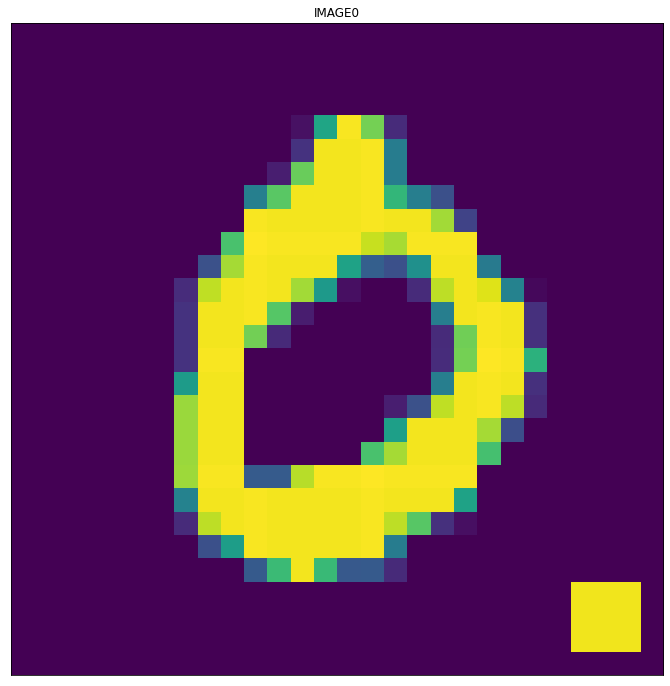

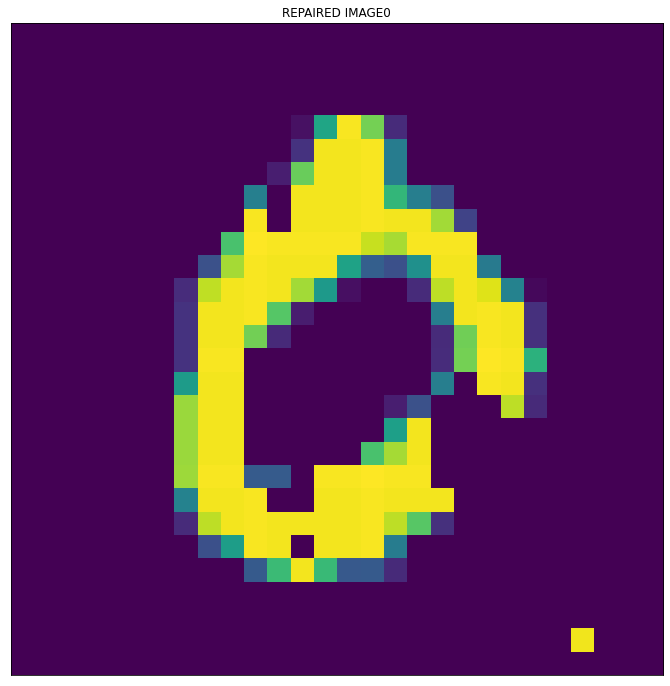

In [22]:
### BASED ON DIFF GRADCAM
import copy
wrongsolve=0
x = copy.deepcopy(val_data) 
cnt = 0
correct = 0

labels = actuals_val 
ideals = val_labels 
start_time = time.time()


test_labels = (model.predict(x)).argmax(axis=1)
PASSA = 0
FAILA = 0
for indx in range(0, firsthalf):
  if (test_labels[indx] == ideals[indx]):
    PASSA = PASSA + 1
  else:
    FAILA = FAILA + 1
print("PASS:", PASSA, ",FAIL:", FAILA,"," ,",CLEAN TEST ACCURACY:", (PASSA/(PASSA+FAILA))*100.0)
PASSB = 0
FAILB = 0
for indx in range(firsthalf, len(x)):
  if (test_labels[indx] == ideals[indx]):
    PASSB = PASSB + 1
  else:
    FAILB = FAILB + 1
print("PASS:", PASSB, ",FAIL:", FAILB,"," ,",Poisoned TEST ACCURACY:", (PASSB/(PASSB+FAILB))*100.0)
print("PASS:", PASSA+PASSB, ",FAIL:", FAILA+FAILB,"," ,",Overall TEST ACCURACY:", ((PASSA+PASSB)/(PASSA+PASSB+FAILA+FAILB))*100.0)

print("--- %s seconds ---" % (time.time() - start_time))





start_time = time.time()

true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0
ss=""

PRINT = True
for inp_cnt in range(0,len(x)): # x is the list of images in the dataset used to extract the mis-classification pattern
    
    image = x[inp_cnt]
    label = labels[inp_cnt]
    
    inp = image 
  
    if (VAL == False):
        inc_layer = 'activation_3'  #layer name, get it from the model summary
        inc_suff = fingerprint_suffix_vals(inp, inc_layer)

        neuron_ids =[]
        inc_neuron_ids=[]
        neuron_sig = []

        for indx in range (0, len(Ainvs_sel_neus)):
          neu_ids = []
          for indx1 in range (0, len(Ainvs_sel_neus[indx])):
              neu_ids.append(-1)
              neu_ids.append(Ainvs_sel_neus[indx][indx1])
          neuron_ids.append(neu_ids)
          inc_neuron_ids.append(Ainvs_sel_neus[indx])

        for indx in range (0, len(Ainvs_sel_sig)):
          neuron_sig.append(Ainvs_sel_sig[indx])

        layer_vals = [] 
        suff = inc_suff
        
    else:
     
        inc_layer = 'activation_3'  #layer name, get it from the model summary
        inc_suff = fingerprint_suffix_vals(inp, inc_layer)

        neuron_ids =[]
        inc_neuron_ids=[]
        neuron_sig = []

        for indx in range (0, len(invs_sel_neus)):
          neu_ids = []
          for indx1 in range (0, len(invs_sel_neus[indx])):
              neu_ids.append(-1)
              neu_ids.append(invs_sel_neus[indx][indx1])
          neuron_ids.append(neu_ids)
          inc_neuron_ids.append(invs_sel_neus[indx])

        for indx in range (0, len(invs_sel_sig)):
          neuron_sig.append(invs_sel_sig[indx])

        layer_vals = inc_suff[0]
        suff = []
  
    image_array = np.zeros((1,28,28,1),dtype=int)
    image_array[0]=image
    
    match = check_pattern_inter(layer_vals,suff,neuron_ids,neuron_sig,VAL,False)
    if (match >= 0):
        

        #print("IDENTIFIED POISONED INPUT", inp_cnt,",", cnt, ",ACTUAL:", labels[inp_cnt], ",IDEAL:", ideals[inp_cnt])
        
        if (inp_cnt>=firsthalf):
          true_positives = true_positives + 1
        else: 
          false_positives = false_positives + 1
        
        if (labels[inp_cnt] == 7 and (labels[inp_cnt] != ideals[inp_cnt]) and PRINT == True and match==0):
                print("BEFORE REPAIR",img.shape,image.shape)
                subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (12, 12),'subplot_kw': {'xticks': [], 'yticks': []} }
                f, ax = plt.subplots(**subplot_args)
                ax.set_title('IMAGE'+str(match))
                norm_img = np.zeros((28,28,1),dtype=float)
                for ix in range(0,28):
                  for iy in range(0,28):
                      norm_img[ix][iy][0] = (image[ix][iy][0])
                img1 = norm_img.reshape(28,28)
                ax.imshow(img1)
                ss=""
                for i in range(0,28):
                  for j in range(0,28):
                      ss=ss+str(image[i][j])+","
                

        image_array = np.zeros((1,28,28,1),dtype=int)
        image_array[0] = image
        label = (model.predict(image_array)).argmax(axis=1)

        #vals=[]
        #for ix in range(0,32):
        #    for iy in range(0,32):
        #        #if (diff_pat[match][0][ix][iy] not in vals):
        #        vals.append(diff_pat[match][0][ix][iy])
           
        #vals.sort(reverse=True)
        #top_10_percent = int((10/100)*(len(vals)))
        #print(len(vals),top_10_percent, vals[top_10_percent])
        #print(vals[top_10_percent])
        #print(diff_pat[match][0])
        #if(true_positives==1):
          #for ix in range(0,32):
            #for iy in range(0,32):
              #if(diff_pat[match][0][ix][iy]>vals[top_10_percent]):
              #print(ix,iy,diff_pat[match][0][ix][iy])
          
        for ix in range(0,28):
            for iy in range(0,28):
                fnd = 0
                for rem in range(0,len(REM10[match])):
                    (rem_ix,rem_iy) = REM10[match][rem]
                    if (rem_ix == ix and rem_iy == iy):
                      image[ix][iy][0]=0
                      fnd = 1
                      break
        #for ix in range(0,32):
        #    for iy in range(0,32):
        #        if (diff_pat[match][0][ix][iy] > vals[top_10_percent] and diff_pat[match][0][ix][iy] > 0.0):
        #          #print(ix,iy)
        #          image[ix][iy][0] = 0
        #          image[ix][iy][1] = 0
        #          image[ix][iy][2] = 0
              
        if (labels[inp_cnt] == 7 and (labels[inp_cnt] != ideals[inp_cnt]) and PRINT == True and match==0):
                PRINT = False
                print("AFTER REPAIR")
                subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (12, 12),'subplot_kw': {'xticks': [], 'yticks': []} }
                f, ax = plt.subplots(**subplot_args)
                ax.set_title('REPAIRED IMAGE'+str(match))
                norm_img = np.zeros((28,28,1),dtype=float)
                for ix in range(0,28):
                  for iy in range(0,28):
                    norm_img[ix][iy][0] = (image[ix][iy][0])
                img1 = norm_img.reshape(28,28)
                ax.imshow(img1)
          
        image_array = np.zeros((1,28,28,1),dtype=int)
        image_array[0]=image
        new_label = (model.predict(image_array)).argmax(axis=1)
        if (labels[inp_cnt] == ideals[inp_cnt] and new_label != ideals[inp_cnt]):
          wrongsolve=wrongsolve+1
        #print("OLD LABEL:", label," ",labels[inp_cnt] ,",REPAIRED LABEL:", new_label, ",CORRECT LABEL:", ideals[inp_cnt])
        if ((ideals[inp_cnt] != label) and (ideals[inp_cnt] == new_label)):
            correct = correct + 1
        cnt = cnt + 1    
    else:
      if (inp_cnt>=firsthalf):
          false_negatives = false_negatives + 1
      else: 
          true_negatives = true_negatives + 1
        

print('CNT:',cnt)

print('TP:', true_positives, ',FP:', false_positives, ",TN:", true_negatives, ",FN:", false_negatives)
PREC = ((true_positives)/ (true_positives + false_positives))
RECALL = ((true_positives)/ (true_positives + false_negatives))
print("PRECISION:" , PREC * 100.0, ",RECALL:", RECALL * 100.0)

print('CORRECT:', correct)
rep_rate = ((correct/true_positives) * 100.0)
print("REPAIR RATE:", rep_rate)
print(ss)
print("--- %s seconds ---" % (time.time() - start_time))


start_time = time.time()

test_labels = (model.predict(x)).argmax(axis=1)
PASSA = 0
FAILA = 0
for indx in range(0, firsthalf):
  if (test_labels[indx] == ideals[indx]):
    PASSA = PASSA + 1
  else:
    FAILA = FAILA + 1
print("PASS:", PASSA, ",FAIL:", FAILA,"," ,",CLEAN TEST ACCURACY:", (PASSA/(PASSA+FAILA))*100.0)
PASSB = 0
FAILB = 0
for indx in range(firsthalf, len(x)):
  if (test_labels[indx] == ideals[indx]):
    PASSB = PASSB + 1
  else:
    FAILB = FAILB + 1
print("PASS:", PASSB, ",FAIL:", FAILB,"," ,",Poisoned TEST ACCURACY:", (PASSB/(PASSB+FAILB))*100.0)
print("PASS:", PASSA+PASSB, ",FAIL:", FAILA+FAILB,"," ,",Overall TEST ACCURACY:", ((PASSA+PASSB)/(PASSA+PASSB+FAILA+FAILB))*100.0)

print("--- %s seconds ---" % (time.time() - start_time))

